In [1]:
import cv2
import numpy as np
import pandas as pd
import os
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow.keras as K
import tensorflow.keras.backend as Kback
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
import matplotlib.pyplot as plt

# from google.colab import drive
# drive.mount('/content/drive')

# DCT

In [2]:
from scipy.fftpack import dct

def dct_2d(a):
    t = dct(dct(a.T).T)
    return t[0][0],t[0][1],t[1][0],t[2][0],t[0][2],t[2][2],t[0][4],t[4][0],t[3][2],t[2][3]

In [3]:
def channel_attention_module(x, ratio=8):
    batch, _, _, channel = x.shape
    ## Shared layers
    l1 = K.layers.Dense(channel//ratio, activation="relu", use_bias=False)
    l2 = K.layers.Dense(channel, use_bias=False)
    ## Global Average Pooling
    x1 = K.layers.GlobalAveragePooling2D()(x)
    x1 = l1(x1)
    x1 = l2(x1)
    ## Global Max Pooling
    x2 = K.layers.GlobalMaxPooling2D()(x)
    x2 = l1(x2)
    x2 = l2(x2)
    ## Add both the features and pass through sigmoid
    feats = x1 + x2
    feats = K.layers.Activation("sigmoid")(feats)
    feats = K.layers.Multiply()([x, feats])

    return feats

def spatial_attention_module(x):
    ## Average Pooling
    x1 = tf.reduce_mean(x, axis=-1)
    x1 = tf.expand_dims(x1, axis=-1)
    ## Max Pooling
    x2 = tf.reduce_max(x, axis=-1)
    x2 = tf.expand_dims(x2, axis=-1)
    ## Concatenat both the features
    feats = K.layers.Concatenate()([x1, x2])
    ## Conv layer
    feats = K.layers.Conv2D(1, kernel_size=7, padding="same", activation="sigmoid")(feats)
    feats = K.layers.Multiply()([x, feats])

    return feats

def cbam(x):
    x = channel_attention_module(x)
    x = spatial_attention_module(x)
    return x

# Model Training

In [4]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = Kback.sum(Kback.round(Kback.clip(y_true * y_pred, 0, 1)))
    possible_positives = Kback.sum(Kback.round(Kback.clip(y_true, 0, 1)))
    predicted_positives = Kback.sum(Kback.round(Kback.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + Kback.epsilon())
    recall = true_positives / (possible_positives + Kback.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+Kback.epsilon())
    return f1_val

METRICS = [
      "accuracy",
      K.metrics.Precision(name='precision'),
      K.metrics.Recall(name='recall'),
      K.metrics.AUC(name='auc'),
      f1_score
]

# Data Loading

In [5]:
model = K.models.load_model("densenet121_cbam.hdf5", custom_objects={"f1_score": f1_score, "cbam_lay":cbam})
model.layers[-2]._name='desired'
print(model.layers)

[<keras.engine.input_layer.InputLayer object at 0x000001B292CE5AC0>, <keras.engine.functional.Functional object at 0x000001B292D8E910>, <keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x000001B290251850>, <keras.layers.pooling.global_max_pooling2d.GlobalMaxPooling2D object at 0x000001B290251820>, <keras.layers.core.dense.Dense object at 0x000001B2942DA760>, <keras.layers.core.dense.Dense object at 0x000001B2943BB070>, <keras.layers.core.tf_op_layer.TFOpLambda object at 0x000001B294315370>, <keras.layers.core.activation.Activation object at 0x000001B2931AD280>, <keras.layers.merging.multiply.Multiply object at 0x000001B2931AD040>, <keras.layers.core.tf_op_layer.TFOpLambda object at 0x000001B295415100>, <keras.layers.core.tf_op_layer.TFOpLambda object at 0x000001B29436DEB0>, <keras.layers.core.tf_op_layer.TFOpLambda object at 0x000001B2931A3880>, <keras.layers.core.tf_op_layer.TFOpLambda object at 0x000001B2943978B0>, <keras.layers.merging.concatenate.Conc

In [6]:
def visualize_conv_layer(layer_name, inputs):
    layer_output=model.get_layer(layer_name).output  #get the Output of the Layer
    intermediate_model=tf.keras.models.Model(inputs=model.input,outputs=layer_output) #Intermediate model between Input Layer and Output Layer which we want
    intermediate_prediction=intermediate_model.predict(inputs) #predicting in the Intermediate Node
    return intermediate_prediction

In [7]:
import os
import random
import numpy as np

Y_train = []
X_train = []
dct_train = []
for i in range(1,21):
    folder = "D:/RESEARCH/Circuit component recognition/train/"+str(i)+"/"
    for image in os.listdir(os.path.join(folder)):
        I = []
        img = cv2.imread(os.path.join(folder,image))
        img = cv2.resize(img, (160, 160))
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = img/255
        dct_train.append(dct_2d(img_gray))
        I.append(img)
        I = np.asarray(I)
        des = visualize_conv_layer('desired', I)[0]
        print(i)
        print(image)
        X_train.append(des)
        Y_train.append(i)

Y_train = np.asarray(Y_train)
X_train = np.asarray(X_train)
dct_train = np.asarray(dct_train)
X_train = np.column_stack((X_train, dct_train))

Y_test = []
X_test = []
dct_test = []
for i in range(1,21):
    folder = "D:/RESEARCH/Circuit component recognition/test/"+str(i)+"/"
    for image in os.listdir(os.path.join(folder)):
        I = []
        img = cv2.imread(os.path.join(folder,image))
        img = cv2.resize(img, (160, 160))
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = img/255
        dct_test.append(dct_2d(img_gray))
        I.append(img)
        I = np.asarray(I)
        des = visualize_conv_layer('desired', I)[0]
        print(i)
        print(image)
        X_test.append(des)
        Y_test.append(i)

Y_test = np.asarray(Y_test)
X_test = np.asarray(X_test)
dct_test = np.asarray(dct_test)
X_test = np.column_stack((X_test, dct_test))

shuffler = np.random.permutation(len(X_train))
X_train = X_train[shuffler]
Y_train = Y_train[shuffler]

shuffler = np.random.permutation(len(X_test))
X_test = X_test[shuffler]
Y_test = Y_test[shuffler]

1/1 [==============================] - 4s 4s/step
1
componentl001.bmp
1/1 [==============================] - 4s 4s/step
1
componentl001arbirot.bmp
1/1 [==============================] - 4s 4s/step
1
componentl001binfil.bmp
1/1 [==============================] - 4s 4s/step
1
componentl001bright.bmp


5 out of the last 5 calls to <function Model.make_predict_function.<locals>.predict_function at 0x000001B29D03E160> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 4s 4s/step
1
componentl001contrast.bmp


6 out of the last 6 calls to <function Model.make_predict_function.<locals>.predict_function at 0x000001B29F32A1F0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


1/1 [==============================] - 4s 4s/step
1
componentl001dilated.bmp
1/1 [==============================] - 4s 4s/step
1
componentl001rotneg.bmp
1/1 [==============================] - 4s 4s/step
1
componentl001rotpos.bmp
1/1 [==============================] - 4s 4s/step
1
componentl002.bmp
1/1 [==============================] - 4s 4s/step
1
componentl002arbirot.bmp
1/1 [==============================] - 4s 4s/step
1
componentl002binfil.bmp
1/1 [==============================] - 5s 5s/step
1
componentl002bright.bmp
1/1 [==============================] - 4s 4s/step
1
componentl002contrast.bmp
1/1 [==============================] - 4s 4s/step
1
componentl002dilated.bmp
1/1 [==============================] - 4s 4s/step
1
componentl002rotneg.bmp
1/1 [==============================] - 4s 4s/step
1
componentl002rotpos.bmp
1/1 [==============================] - 4s 4s/step
1
componentl003.bmp
1/1 [==============================] - 5s 5s/step
1
componentl003arbirot.bmp
1/1 [=============

1/1 [==============================] - 4s 4s/step
1
componentl015arbirot.bmp
1/1 [==============================] - 4s 4s/step
1
componentl015binfil.bmp
1/1 [==============================] - 4s 4s/step
1
componentl015bright.bmp
1/1 [==============================] - 5s 5s/step
1
componentl015contrast.bmp
1/1 [==============================] - 4s 4s/step
1
componentl015dilated.bmp
1/1 [==============================] - 4s 4s/step
1
componentl015rotneg.bmp
1/1 [==============================] - 4s 4s/step
1
componentl015rotpos.bmp
1/1 [==============================] - 4s 4s/step
1
componentl016.bmp
1/1 [==============================] - 4s 4s/step
1
componentl016arbirot.bmp
1/1 [==============================] - 5s 5s/step
1
componentl016binfil.bmp
1/1 [==============================] - 4s 4s/step
1
componentl016bright.bmp
1/1 [==============================] - 4s 4s/step
1
componentl016contrast.bmp
1/1 [==============================] - 4s 4s/step
1
componentl016dilated.bmp
1/1 [=====

1/1 [==============================] - 5s 5s/step
1
componentl028dilated.bmp
1/1 [==============================] - 4s 4s/step
1
componentl028rotneg.bmp
1/1 [==============================] - 4s 4s/step
1
componentl028rotpos.bmp
1/1 [==============================] - 4s 4s/step
1
componentl029.bmp
1/1 [==============================] - 4s 4s/step
1
componentl029arbirot.bmp
1/1 [==============================] - 4s 4s/step
1
componentl029binfil.bmp
1/1 [==============================] - 5s 5s/step
1
componentl029bright.bmp
1/1 [==============================] - 4s 4s/step
1
componentl029contrast.bmp
1/1 [==============================] - 4s 4s/step
1
componentl029dilated.bmp
1/1 [==============================] - 4s 4s/step
1
componentl029rotneg.bmp
1/1 [==============================] - 4s 4s/step
1
componentl029rotpos.bmp
1/1 [==============================] - 4s 4s/step
1
componentl030.bmp
1/1 [==============================] - 4s 4s/step
1
componentl030arbirot.bmp
1/1 [=============

1/1 [==============================] - 4s 4s/step
1
componentl042arbirot.bmp
1/1 [==============================] - 4s 4s/step
1
componentl042binfil.bmp
1/1 [==============================] - 4s 4s/step
1
componentl042bright.bmp
1/1 [==============================] - 5s 5s/step
1
componentl042contrast.bmp
1/1 [==============================] - 4s 4s/step
1
componentl042dilated.bmp
1/1 [==============================] - 4s 4s/step
1
componentl042rotneg.bmp
1/1 [==============================] - 4s 4s/step
1
componentl042rotpos.bmp
1/1 [==============================] - 4s 4s/step
1
componentl043.bmp
1/1 [==============================] - 4s 4s/step
1
componentl043arbirot.bmp
1/1 [==============================] - 5s 5s/step
1
componentl043binfil.bmp
1/1 [==============================] - 4s 4s/step
1
componentl043bright.bmp
1/1 [==============================] - 4s 4s/step
1
componentl043contrast.bmp
1/1 [==============================] - 4s 4s/step
1
componentl043dilated.bmp
1/1 [=====

1/1 [==============================] - 2s 2s/step
1
componentlblurG44.bmp
1/1 [==============================] - 3s 3s/step
1
componentlblurG45.bmp
1/1 [==============================] - 2s 2s/step
1
componentlblurG46.bmp
1/1 [==============================] - 2s 2s/step
1
componentlblurG47.bmp
1/1 [==============================] - 2s 2s/step
1
componentlblurG48.bmp
1/1 [==============================] - 2s 2s/step
1
componentlblurG49.bmp
1/1 [==============================] - 2s 2s/step
1
componentlblurG5.bmp
1/1 [==============================] - 2s 2s/step
1
componentlblurG50.bmp
1/1 [==============================] - 2s 2s/step
1
componentlblurG6.bmp
1/1 [==============================] - 2s 2s/step
1
componentlblurG7.bmp
1/1 [==============================] - 2s 2s/step
1
componentlblurG8.bmp
1/1 [==============================] - 2s 2s/step
1
componentlblurG9.bmp
1/1 [==============================] - 3s 3s/step
1
componentlnoise1.bmp
1/1 [==============================] - 2s 2s

1/1 [==============================] - 3s 3s/step
2
componentl007.bmp
1/1 [==============================] - 3s 3s/step
2
componentl007arbirot.bmp
1/1 [==============================] - 3s 3s/step
2
componentl007binfil.bmp
1/1 [==============================] - 3s 3s/step
2
componentl007bright.bmp
1/1 [==============================] - 3s 3s/step
2
componentl007contrast.bmp
1/1 [==============================] - 3s 3s/step
2
componentl007dilated.bmp
1/1 [==============================] - 3s 3s/step
2
componentl007rotneg.bmp
1/1 [==============================] - 3s 3s/step
2
componentl007rotpos.bmp
1/1 [==============================] - 3s 3s/step
2
componentl008.bmp
1/1 [==============================] - 3s 3s/step
2
componentl008arbirot.bmp
1/1 [==============================] - 3s 3s/step
2
componentl008binfil.bmp
1/1 [==============================] - 3s 3s/step
2
componentl008bright.bmp
1/1 [==============================] - 3s 3s/step
2
componentl008contrast.bmp
1/1 [============

1/1 [==============================] - 6s 6s/step
2
componentl020contrast.bmp
1/1 [==============================] - 5s 5s/step
2
componentl020dilated.bmp
1/1 [==============================] - 6s 6s/step
2
componentl020rotneg.bmp
1/1 [==============================] - 5s 5s/step
2
componentl020rotpos.bmp
1/1 [==============================] - 6s 6s/step
2
componentl021.bmp
1/1 [==============================] - 5s 5s/step
2
componentl021arbirot.bmp
1/1 [==============================] - 5s 5s/step
2
componentl021binfil.bmp
1/1 [==============================] - 5s 5s/step
2
componentl021bright.bmp
1/1 [==============================] - 5s 5s/step
2
componentl021contrast.bmp
1/1 [==============================] - 4s 4s/step
2
componentl021dilated.bmp
1/1 [==============================] - 6s 6s/step
2
componentl021rotneg.bmp
1/1 [==============================] - 5s 5s/step
2
componentl021rotpos.bmp
1/1 [==============================] - 5s 5s/step
2
componentl022.bmp
1/1 [============

1/1 [==============================] - 3s 3s/step
2
componentl034.bmp
1/1 [==============================] - 4s 4s/step
2
componentl034arbirot.bmp
1/1 [==============================] - 3s 3s/step
2
componentl034binfil.bmp
1/1 [==============================] - 4s 4s/step
2
componentl034bright.bmp
1/1 [==============================] - 4s 4s/step
2
componentl034contrast.bmp
1/1 [==============================] - 4s 4s/step
2
componentl034dilated.bmp
1/1 [==============================] - 3s 3s/step
2
componentl034rotneg.bmp
1/1 [==============================] - 3s 3s/step
2
componentl034rotpos.bmp
1/1 [==============================] - 4s 4s/step
2
componentl035.bmp
1/1 [==============================] - 3s 3s/step
2
componentl035arbirot.bmp
1/1 [==============================] - 2s 2s/step
2
componentl035binfil.bmp
1/1 [==============================] - 3s 3s/step
2
componentl035bright.bmp
1/1 [==============================] - 2s 2s/step
2
componentl035contrast.bmp
1/1 [============

1/1 [==============================] - 3s 3s/step
2
componentl047contrast.bmp
1/1 [==============================] - 3s 3s/step
2
componentl047dilated.bmp
1/1 [==============================] - 3s 3s/step
2
componentl047rotneg.bmp
1/1 [==============================] - 3s 3s/step
2
componentl047rotpos.bmp
1/1 [==============================] - 3s 3s/step
2
componentl048.bmp
1/1 [==============================] - 3s 3s/step
2
componentl048arbirot.bmp
1/1 [==============================] - 4s 4s/step
2
componentl048binfil.bmp
1/1 [==============================] - 3s 3s/step
2
componentl048bright.bmp
1/1 [==============================] - 3s 3s/step
2
componentl048contrast.bmp
1/1 [==============================] - 2s 2s/step
2
componentl048dilated.bmp
1/1 [==============================] - 3s 3s/step
2
componentl048rotneg.bmp
1/1 [==============================] - 3s 3s/step
2
componentl048rotpos.bmp
1/1 [==============================] - 2s 2s/step
2
componentl049.bmp
1/1 [============

1/1 [==============================] - 2s 2s/step
2
componentlnoise39.bmp
1/1 [==============================] - 2s 2s/step
2
componentlnoise4.bmp
1/1 [==============================] - 3s 3s/step
2
componentlnoise40.bmp
1/1 [==============================] - 2s 2s/step
2
componentlnoise41.bmp
1/1 [==============================] - 2s 2s/step
2
componentlnoise42.bmp
1/1 [==============================] - 2s 2s/step
2
componentlnoise43.bmp
1/1 [==============================] - 3s 3s/step
2
componentlnoise44.bmp
1/1 [==============================] - 3s 3s/step
2
componentlnoise45.bmp
1/1 [==============================] - 3s 3s/step
2
componentlnoise46.bmp
1/1 [==============================] - 3s 3s/step
2
componentlnoise47.bmp
1/1 [==============================] - 3s 3s/step
2
componentlnoise48.bmp
1/1 [==============================] - 3s 3s/step
2
componentlnoise49.bmp
1/1 [==============================] - 3s 3s/step
2
componentlnoise5.bmp
1/1 [==============================] - 3

1/1 [==============================] - 4s 4s/step
3
componentl012bright.bmp
1/1 [==============================] - 4s 4s/step
3
componentl012contrast.bmp
1/1 [==============================] - 4s 4s/step
3
componentl012dilated.bmp
1/1 [==============================] - 4s 4s/step
3
componentl012rotneg.bmp
1/1 [==============================] - 4s 4s/step
3
componentl012rotpos.bmp
1/1 [==============================] - 4s 4s/step
3
componentl013.bmp
1/1 [==============================] - 4s 4s/step
3
componentl013arbirot.bmp
1/1 [==============================] - 4s 4s/step
3
componentl013binfil.bmp
1/1 [==============================] - 4s 4s/step
3
componentl013bright.bmp
1/1 [==============================] - 4s 4s/step
3
componentl013contrast.bmp
1/1 [==============================] - 4s 4s/step
3
componentl013dilated.bmp
1/1 [==============================] - 4s 4s/step
3
componentl013rotneg.bmp
1/1 [==============================] - 4s 4s/step
3
componentl013rotpos.bmp
1/1 [======

1/1 [==============================] - 2s 2s/step
3
componentl025rotpos.bmp
1/1 [==============================] - 2s 2s/step
3
componentl026.bmp
1/1 [==============================] - 2s 2s/step
3
componentl026arbirot.bmp
1/1 [==============================] - 2s 2s/step
3
componentl026binfil.bmp
1/1 [==============================] - 2s 2s/step
3
componentl026bright.bmp
1/1 [==============================] - 2s 2s/step
3
componentl026contrast.bmp
1/1 [==============================] - 2s 2s/step
3
componentl026dilated.bmp
1/1 [==============================] - 2s 2s/step
3
componentl026rotneg.bmp
1/1 [==============================] - 2s 2s/step
3
componentl026rotpos.bmp
1/1 [==============================] - 2s 2s/step
3
componentl027.bmp
1/1 [==============================] - 2s 2s/step
3
componentl027arbirot.bmp
1/1 [==============================] - 2s 2s/step
3
componentl027binfil.bmp
1/1 [==============================] - 2s 2s/step
3
componentl027bright.bmp
1/1 [==============

1/1 [==============================] - 2s 2s/step
3
componentl039bright.bmp
1/1 [==============================] - 3s 3s/step
3
componentl039contrast.bmp
1/1 [==============================] - 2s 2s/step
3
componentl039dilated.bmp
1/1 [==============================] - 3s 3s/step
3
componentl039rotneg.bmp
1/1 [==============================] - 3s 3s/step
3
componentl039rotpos.bmp
1/1 [==============================] - 2s 2s/step
3
componentl040.bmp
1/1 [==============================] - 2s 2s/step
3
componentl040arbirot.bmp
1/1 [==============================] - 2s 2s/step
3
componentl040binfil.bmp
1/1 [==============================] - 2s 2s/step
3
componentl040bright.bmp
1/1 [==============================] - 3s 3s/step
3
componentl040contrast.bmp
1/1 [==============================] - 3s 3s/step
3
componentl040dilated.bmp
1/1 [==============================] - 2s 2s/step
3
componentl040rotneg.bmp
1/1 [==============================] - 2s 2s/step
3
componentl040rotpos.bmp
1/1 [======

1/1 [==============================] - 2s 2s/step
3
componentlblurG23.bmp
1/1 [==============================] - 2s 2s/step
3
componentlblurG24.bmp
1/1 [==============================] - 2s 2s/step
3
componentlblurG25.bmp
1/1 [==============================] - 2s 2s/step
3
componentlblurG26.bmp
1/1 [==============================] - 2s 2s/step
3
componentlblurG27.bmp
1/1 [==============================] - 2s 2s/step
3
componentlblurG28.bmp
1/1 [==============================] - 2s 2s/step
3
componentlblurG29.bmp
1/1 [==============================] - 2s 2s/step
3
componentlblurG3.bmp
1/1 [==============================] - 2s 2s/step
3
componentlblurG30.bmp
1/1 [==============================] - 2s 2s/step
3
componentlblurG31.bmp
1/1 [==============================] - 2s 2s/step
3
componentlblurG32.bmp
1/1 [==============================] - 2s 2s/step
3
componentlblurG33.bmp
1/1 [==============================] - 2s 2s/step
3
componentlblurG34.bmp
1/1 [==============================] - 

1/1 [==============================] - 2s 2s/step
4
componentl004arbirot.bmp
1/1 [==============================] - 2s 2s/step
4
componentl004binfil.bmp
1/1 [==============================] - 2s 2s/step
4
componentl004bright.bmp
1/1 [==============================] - 2s 2s/step
4
componentl004contrast.bmp
1/1 [==============================] - 3s 3s/step
4
componentl004dilated.bmp
1/1 [==============================] - 2s 2s/step
4
componentl004rotneg.bmp
1/1 [==============================] - 2s 2s/step
4
componentl004rotpos.bmp
1/1 [==============================] - 2s 2s/step
4
componentl005.bmp
1/1 [==============================] - 2s 2s/step
4
componentl005arbirot.bmp
1/1 [==============================] - 2s 2s/step
4
componentl005binfil.bmp
1/1 [==============================] - 3s 3s/step
4
componentl005bright.bmp
1/1 [==============================] - 2s 2s/step
4
componentl005contrast.bmp
1/1 [==============================] - 2s 2s/step
4
componentl005dilated.bmp
1/1 [=====

1/1 [==============================] - 2s 2s/step
4
componentl017dilated.bmp
1/1 [==============================] - 2s 2s/step
4
componentl017rotneg.bmp
1/1 [==============================] - 2s 2s/step
4
componentl017rotpos.bmp
1/1 [==============================] - 3s 3s/step
4
componentl018.bmp
1/1 [==============================] - 2s 2s/step
4
componentl018arbirot.bmp
1/1 [==============================] - 2s 2s/step
4
componentl018binfil.bmp
1/1 [==============================] - 2s 2s/step
4
componentl018bright.bmp
1/1 [==============================] - 2s 2s/step
4
componentl018contrast.bmp
1/1 [==============================] - 2s 2s/step
4
componentl018dilated.bmp
1/1 [==============================] - 2s 2s/step
4
componentl018rotneg.bmp
1/1 [==============================] - 2s 2s/step
4
componentl018rotpos.bmp
1/1 [==============================] - 2s 2s/step
4
componentl019.bmp
1/1 [==============================] - 2s 2s/step
4
componentl019arbirot.bmp
1/1 [=============

1/1 [==============================] - 2s 2s/step
4
componentl031arbirot.bmp
1/1 [==============================] - 3s 3s/step
4
componentl031binfil.bmp
1/1 [==============================] - 2s 2s/step
4
componentl031bright.bmp
1/1 [==============================] - 2s 2s/step
4
componentl031contrast.bmp
1/1 [==============================] - 2s 2s/step
4
componentl031dilated.bmp
1/1 [==============================] - 2s 2s/step
4
componentl031rotneg.bmp
1/1 [==============================] - 3s 3s/step
4
componentl031rotpos.bmp
1/1 [==============================] - 2s 2s/step
4
componentl032.bmp
1/1 [==============================] - 2s 2s/step
4
componentl032arbirot.bmp
1/1 [==============================] - 2s 2s/step
4
componentl032binfil.bmp
1/1 [==============================] - 2s 2s/step
4
componentl032bright.bmp
1/1 [==============================] - 3s 3s/step
4
componentl032contrast.bmp
1/1 [==============================] - 3s 3s/step
4
componentl032dilated.bmp
1/1 [=====

1/1 [==============================] - 2s 2s/step
4
componentl044dilated.bmp
1/1 [==============================] - 2s 2s/step
4
componentl044rotneg.bmp
1/1 [==============================] - 2s 2s/step
4
componentl044rotpos.bmp
1/1 [==============================] - 3s 3s/step
4
componentl045.bmp
1/1 [==============================] - 2s 2s/step
4
componentl045arbirot.bmp
1/1 [==============================] - 2s 2s/step
4
componentl045binfil.bmp
1/1 [==============================] - 2s 2s/step
4
componentl045bright.bmp
1/1 [==============================] - 2s 2s/step
4
componentl045contrast.bmp
1/1 [==============================] - 2s 2s/step
4
componentl045dilated.bmp
1/1 [==============================] - 3s 3s/step
4
componentl045rotneg.bmp
1/1 [==============================] - 2s 2s/step
4
componentl045rotpos.bmp
1/1 [==============================] - 2s 2s/step
4
componentl046.bmp
1/1 [==============================] - 2s 2s/step
4
componentl046arbirot.bmp
1/1 [=============

1/1 [==============================] - 3s 3s/step
4
componentlnoise17.bmp
1/1 [==============================] - 2s 2s/step
4
componentlnoise18.bmp
1/1 [==============================] - 3s 3s/step
4
componentlnoise19.bmp
1/1 [==============================] - 3s 3s/step
4
componentlnoise2.bmp
1/1 [==============================] - 2s 2s/step
4
componentlnoise20.bmp
1/1 [==============================] - 3s 3s/step
4
componentlnoise21.bmp
1/1 [==============================] - 2s 2s/step
4
componentlnoise22.bmp
1/1 [==============================] - 2s 2s/step
4
componentlnoise23.bmp
1/1 [==============================] - 2s 2s/step
4
componentlnoise24.bmp
1/1 [==============================] - 2s 2s/step
4
componentlnoise25.bmp
1/1 [==============================] - 2s 2s/step
4
componentlnoise26.bmp
1/1 [==============================] - 3s 3s/step
4
componentlnoise27.bmp
1/1 [==============================] - 2s 2s/step
4
componentlnoise28.bmp
1/1 [==============================] - 

1/1 [==============================] - 2s 2s/step
5
componentl009bright.bmp
1/1 [==============================] - 2s 2s/step
5
componentl009contrast.bmp
1/1 [==============================] - 3s 3s/step
5
componentl009dilated.bmp
1/1 [==============================] - 2s 2s/step
5
componentl009rotneg.bmp
1/1 [==============================] - 2s 2s/step
5
componentl009rotpos.bmp
1/1 [==============================] - 2s 2s/step
5
componentl010.bmp
1/1 [==============================] - 2s 2s/step
5
componentl010arbirot.bmp
1/1 [==============================] - 3s 3s/step
5
componentl010binfil.bmp
1/1 [==============================] - 2s 2s/step
5
componentl010bright.bmp
1/1 [==============================] - 2s 2s/step
5
componentl010contrast.bmp
1/1 [==============================] - 2s 2s/step
5
componentl010dilated.bmp
1/1 [==============================] - 2s 2s/step
5
componentl010rotneg.bmp
1/1 [==============================] - 2s 2s/step
5
componentl010rotpos.bmp
1/1 [======

1/1 [==============================] - 3s 3s/step
5
componentl022rotpos.bmp
1/1 [==============================] - 3s 3s/step
5
componentl023.bmp
1/1 [==============================] - 3s 3s/step
5
componentl023arbirot.bmp
1/1 [==============================] - 3s 3s/step
5
componentl023binfil.bmp
1/1 [==============================] - 3s 3s/step
5
componentl023bright.bmp
1/1 [==============================] - 3s 3s/step
5
componentl023contrast.bmp
1/1 [==============================] - 3s 3s/step
5
componentl023dilated.bmp
1/1 [==============================] - 3s 3s/step
5
componentl023rotneg.bmp
1/1 [==============================] - 3s 3s/step
5
componentl023rotpos.bmp
1/1 [==============================] - 3s 3s/step
5
componentl024.bmp
1/1 [==============================] - 3s 3s/step
5
componentl024arbirot.bmp
1/1 [==============================] - 3s 3s/step
5
componentl024binfil.bmp
1/1 [==============================] - 2s 2s/step
5
componentl024bright.bmp
1/1 [==============

1/1 [==============================] - 2s 2s/step
5
componentl036bright.bmp
1/1 [==============================] - 2s 2s/step
5
componentl036contrast.bmp
1/1 [==============================] - 3s 3s/step
5
componentl036dilated.bmp
1/1 [==============================] - 2s 2s/step
5
componentl036rotneg.bmp
1/1 [==============================] - 2s 2s/step
5
componentl036rotpos.bmp
1/1 [==============================] - 2s 2s/step
5
componentl037.bmp
1/1 [==============================] - 2s 2s/step
5
componentl037arbirot.bmp
1/1 [==============================] - 2s 2s/step
5
componentl037binfil.bmp
1/1 [==============================] - 3s 3s/step
5
componentl037bright.bmp
1/1 [==============================] - 3s 3s/step
5
componentl037contrast.bmp
1/1 [==============================] - 2s 2s/step
5
componentl037dilated.bmp
1/1 [==============================] - 2s 2s/step
5
componentl037rotneg.bmp
1/1 [==============================] - 2s 2s/step
5
componentl037rotpos.bmp
1/1 [======

1/1 [==============================] - 3s 3s/step
5
componentl049rotpos.bmp
1/1 [==============================] - 2s 2s/step
5
componentl050.bmp
1/1 [==============================] - 2s 2s/step
5
componentl050arbirot.bmp
1/1 [==============================] - 3s 3s/step
5
componentl050binfil.bmp
1/1 [==============================] - 2s 2s/step
5
componentl050bright.bmp
1/1 [==============================] - 2s 2s/step
5
componentl050contrast.bmp
1/1 [==============================] - 3s 3s/step
5
componentl050dilated.bmp
1/1 [==============================] - 2s 2s/step
5
componentl050rotneg.bmp
1/1 [==============================] - 2s 2s/step
5
componentl050rotpos.bmp
1/1 [==============================] - 2s 2s/step
5
componentlblurG1.bmp
1/1 [==============================] - 2s 2s/step
5
componentlblurG10.bmp
1/1 [==============================] - 3s 3s/step
5
componentlblurG11.bmp
1/1 [==============================] - 2s 2s/step
5
componentlblurG12.bmp
1/1 [==================

1/1 [==============================] - 4s 4s/step
6
componentl001binfil.bmp
1/1 [==============================] - 4s 4s/step
6
componentl001bright.bmp
1/1 [==============================] - 9s 9s/step
6
componentl001contrast.bmp
1/1 [==============================] - 7s 7s/step
6
componentl001dilated.bmp
1/1 [==============================] - 5s 5s/step
6
componentl001rotneg.bmp
1/1 [==============================] - 4s 4s/step
6
componentl001rotpos.bmp
1/1 [==============================] - 4s 4s/step
6
componentl002.bmp
1/1 [==============================] - 3s 3s/step
6
componentl002arbirot.bmp
1/1 [==============================] - 3s 3s/step
6
componentl002binfil.bmp
1/1 [==============================] - 3s 3s/step
6
componentl002bright.bmp
1/1 [==============================] - 3s 3s/step
6
componentl002contrast.bmp
1/1 [==============================] - 3s 3s/step
6
componentl002dilated.bmp
1/1 [==============================] - 4s 4s/step
6
componentl002rotneg.bmp
1/1 [======

1/1 [==============================] - 2s 2s/step
6
componentl014rotneg.bmp
1/1 [==============================] - 2s 2s/step
6
componentl014rotpos.bmp
1/1 [==============================] - 2s 2s/step
6
componentl015.bmp
1/1 [==============================] - 3s 3s/step
6
componentl015arbirot.bmp
1/1 [==============================] - 2s 2s/step
6
componentl015binfil.bmp
1/1 [==============================] - 2s 2s/step
6
componentl015bright.bmp
1/1 [==============================] - 2s 2s/step
6
componentl015contrast.bmp
1/1 [==============================] - 2s 2s/step
6
componentl015dilated.bmp
1/1 [==============================] - 2s 2s/step
6
componentl015rotneg.bmp
1/1 [==============================] - 3s 3s/step
6
componentl015rotpos.bmp
1/1 [==============================] - 2s 2s/step
6
componentl016.bmp
1/1 [==============================] - 2s 2s/step
6
componentl016arbirot.bmp
1/1 [==============================] - 5s 5s/step
6
componentl016binfil.bmp
1/1 [==============

1/1 [==============================] - 3s 3s/step
6
componentl028binfil.bmp
1/1 [==============================] - 2s 2s/step
6
componentl028bright.bmp
1/1 [==============================] - 2s 2s/step
6
componentl028contrast.bmp
1/1 [==============================] - 2s 2s/step
6
componentl028dilated.bmp
1/1 [==============================] - 2s 2s/step
6
componentl028rotneg.bmp
1/1 [==============================] - 2s 2s/step
6
componentl028rotpos.bmp
1/1 [==============================] - 3s 3s/step
6
componentl029.bmp
1/1 [==============================] - 2s 2s/step
6
componentl029arbirot.bmp
1/1 [==============================] - 2s 2s/step
6
componentl029binfil.bmp
1/1 [==============================] - 2s 2s/step
6
componentl029bright.bmp
1/1 [==============================] - 2s 2s/step
6
componentl029contrast.bmp
1/1 [==============================] - 3s 3s/step
6
componentl029dilated.bmp
1/1 [==============================] - 2s 2s/step
6
componentl029rotneg.bmp
1/1 [======

1/1 [==============================] - 2s 2s/step
6
componentl041rotneg.bmp
1/1 [==============================] - 2s 2s/step
6
componentl041rotpos.bmp
1/1 [==============================] - 2s 2s/step
6
componentl042.bmp
1/1 [==============================] - 2s 2s/step
6
componentl042arbirot.bmp
1/1 [==============================] - 3s 3s/step
6
componentl042binfil.bmp
1/1 [==============================] - 2s 2s/step
6
componentl042bright.bmp
1/1 [==============================] - 2s 2s/step
6
componentl042contrast.bmp
1/1 [==============================] - 2s 2s/step
6
componentl042dilated.bmp
1/1 [==============================] - 2s 2s/step
6
componentl042rotneg.bmp
1/1 [==============================] - 3s 3s/step
6
componentl042rotpos.bmp
1/1 [==============================] - 2s 2s/step
6
componentl043.bmp
1/1 [==============================] - 2s 2s/step
6
componentl043arbirot.bmp
1/1 [==============================] - 2s 2s/step
6
componentl043binfil.bmp
1/1 [==============

1/1 [==============================] - 3s 3s/step
6
componentlblurG41.bmp
1/1 [==============================] - 2s 2s/step
6
componentlblurG42.bmp
1/1 [==============================] - 2s 2s/step
6
componentlblurG43.bmp
1/1 [==============================] - 2s 2s/step
6
componentlblurG44.bmp
1/1 [==============================] - 2s 2s/step
6
componentlblurG45.bmp
1/1 [==============================] - 2s 2s/step
6
componentlblurG46.bmp
1/1 [==============================] - 3s 3s/step
6
componentlblurG47.bmp
1/1 [==============================] - 2s 2s/step
6
componentlblurG48.bmp
1/1 [==============================] - 2s 2s/step
6
componentlblurG49.bmp
1/1 [==============================] - 2s 2s/step
6
componentlblurG5.bmp
1/1 [==============================] - 2s 2s/step
6
componentlblurG50.bmp
1/1 [==============================] - 3s 3s/step
6
componentlblurG6.bmp
1/1 [==============================] - 2s 2s/step
6
componentlblurG7.bmp
1/1 [==============================] - 2s

1/1 [==============================] - 2s 2s/step
7
componentl006dilated.bmp
1/1 [==============================] - 3s 3s/step
7
componentl006rotneg.bmp
1/1 [==============================] - 2s 2s/step
7
componentl006rotpos.bmp
1/1 [==============================] - 2s 2s/step
7
componentl007.bmp
1/1 [==============================] - 2s 2s/step
7
componentl007arbirot.bmp
1/1 [==============================] - 2s 2s/step
7
componentl007binfil.bmp
1/1 [==============================] - 2s 2s/step
7
componentl007bright.bmp
1/1 [==============================] - 3s 3s/step
7
componentl007contrast.bmp
1/1 [==============================] - 2s 2s/step
7
componentl007dilated.bmp
1/1 [==============================] - 2s 2s/step
7
componentl007rotneg.bmp
1/1 [==============================] - 2s 2s/step
7
componentl007rotpos.bmp
1/1 [==============================] - 2s 2s/step
7
componentl008.bmp
1/1 [==============================] - 3s 3s/step
7
componentl008arbirot.bmp
1/1 [=============

1/1 [==============================] - 2s 2s/step
7
componentl020arbirot.bmp
1/1 [==============================] - 2s 2s/step
7
componentl020binfil.bmp
1/1 [==============================] - 2s 2s/step
7
componentl020bright.bmp
1/1 [==============================] - 2s 2s/step
7
componentl020contrast.bmp
1/1 [==============================] - 2s 2s/step
7
componentl020dilated.bmp
1/1 [==============================] - 3s 3s/step
7
componentl020rotneg.bmp
1/1 [==============================] - 2s 2s/step
7
componentl020rotpos.bmp
1/1 [==============================] - 2s 2s/step
7
componentl021.bmp
1/1 [==============================] - 4s 4s/step
7
componentl021arbirot.bmp
1/1 [==============================] - 3s 3s/step
7
componentl021binfil.bmp
1/1 [==============================] - 5s 5s/step
7
componentl021bright.bmp
1/1 [==============================] - 4s 4s/step
7
componentl021contrast.bmp
1/1 [==============================] - 2s 2s/step
7
componentl021dilated.bmp
1/1 [=====

1/1 [==============================] - 2s 2s/step
7
componentl033dilated.bmp
1/1 [==============================] - 2s 2s/step
7
componentl033rotneg.bmp
1/1 [==============================] - 2s 2s/step
7
componentl033rotpos.bmp
1/1 [==============================] - 3s 3s/step
7
componentl034.bmp
1/1 [==============================] - 2s 2s/step
7
componentl034arbirot.bmp
1/1 [==============================] - 2s 2s/step
7
componentl034binfil.bmp
1/1 [==============================] - 2s 2s/step
7
componentl034bright.bmp
1/1 [==============================] - 2s 2s/step
7
componentl034contrast.bmp
1/1 [==============================] - 3s 3s/step
7
componentl034dilated.bmp
1/1 [==============================] - 2s 2s/step
7
componentl034rotneg.bmp
1/1 [==============================] - 2s 2s/step
7
componentl034rotpos.bmp
1/1 [==============================] - 2s 2s/step
7
componentl035.bmp
1/1 [==============================] - 2s 2s/step
7
componentl035arbirot.bmp
1/1 [=============

1/1 [==============================] - 3s 3s/step
7
componentl047arbirot.bmp
1/1 [==============================] - 2s 2s/step
7
componentl047binfil.bmp
1/1 [==============================] - 2s 2s/step
7
componentl047bright.bmp
1/1 [==============================] - 2s 2s/step
7
componentl047contrast.bmp
1/1 [==============================] - 2s 2s/step
7
componentl047dilated.bmp
1/1 [==============================] - 2s 2s/step
7
componentl047rotneg.bmp
1/1 [==============================] - 3s 3s/step
7
componentl047rotpos.bmp
1/1 [==============================] - 2s 2s/step
7
componentl048.bmp
1/1 [==============================] - 2s 2s/step
7
componentl048arbirot.bmp
1/1 [==============================] - 2s 2s/step
7
componentl048binfil.bmp
1/1 [==============================] - 2s 2s/step
7
componentl048bright.bmp
1/1 [==============================] - 2s 2s/step
7
componentl048contrast.bmp
1/1 [==============================] - 3s 3s/step
7
componentl048dilated.bmp
1/1 [=====

1/1 [==============================] - 3s 3s/step
7
componentlnoise36.bmp
1/1 [==============================] - 3s 3s/step
7
componentlnoise37.bmp
1/1 [==============================] - 3s 3s/step
7
componentlnoise38.bmp
1/1 [==============================] - 3s 3s/step
7
componentlnoise39.bmp
1/1 [==============================] - 3s 3s/step
7
componentlnoise4.bmp
1/1 [==============================] - 3s 3s/step
7
componentlnoise40.bmp
1/1 [==============================] - 3s 3s/step
7
componentlnoise41.bmp
1/1 [==============================] - 3s 3s/step
7
componentlnoise42.bmp
1/1 [==============================] - 2s 2s/step
7
componentlnoise43.bmp
1/1 [==============================] - 2s 2s/step
7
componentlnoise44.bmp
1/1 [==============================] - 2s 2s/step
7
componentlnoise45.bmp
1/1 [==============================] - 2s 2s/step
7
componentlnoise46.bmp
1/1 [==============================] - 2s 2s/step
7
componentlnoise47.bmp
1/1 [==============================] - 

1/1 [==============================] - 2s 2s/step
8
componentl012.bmp
1/1 [==============================] - 2s 2s/step
8
componentl012arbirot.bmp
1/1 [==============================] - 2s 2s/step
8
componentl012binfil.bmp
1/1 [==============================] - 2s 2s/step
8
componentl012bright.bmp
1/1 [==============================] - 2s 2s/step
8
componentl012contrast.bmp
1/1 [==============================] - 3s 3s/step
8
componentl012dilated.bmp
1/1 [==============================] - 2s 2s/step
8
componentl012rotneg.bmp
1/1 [==============================] - 2s 2s/step
8
componentl012rotpos.bmp
1/1 [==============================] - 2s 2s/step
8
componentl013.bmp
1/1 [==============================] - 2s 2s/step
8
componentl013arbirot.bmp
1/1 [==============================] - 3s 3s/step
8
componentl013binfil.bmp
1/1 [==============================] - 2s 2s/step
8
componentl013bright.bmp
1/1 [==============================] - 2s 2s/step
8
componentl013contrast.bmp
1/1 [============

1/1 [==============================] - 2s 2s/step
8
componentl025contrast.bmp
1/1 [==============================] - 2s 2s/step
8
componentl025dilated.bmp
1/1 [==============================] - 3s 3s/step
8
componentl025rotneg.bmp
1/1 [==============================] - 2s 2s/step
8
componentl025rotpos.bmp
1/1 [==============================] - 2s 2s/step
8
componentl026.bmp
1/1 [==============================] - 2s 2s/step
8
componentl026arbirot.bmp
1/1 [==============================] - 2s 2s/step
8
componentl026binfil.bmp
1/1 [==============================] - 3s 3s/step
8
componentl026bright.bmp
1/1 [==============================] - 2s 2s/step
8
componentl026contrast.bmp
1/1 [==============================] - 2s 2s/step
8
componentl026dilated.bmp
1/1 [==============================] - 2s 2s/step
8
componentl026rotneg.bmp
1/1 [==============================] - 2s 2s/step
8
componentl026rotpos.bmp
1/1 [==============================] - 2s 2s/step
8
componentl027.bmp
1/1 [============

1/1 [==============================] - 3s 3s/step
8
componentl039.bmp
1/1 [==============================] - 2s 2s/step
8
componentl039arbirot.bmp
1/1 [==============================] - 2s 2s/step
8
componentl039binfil.bmp
1/1 [==============================] - 2s 2s/step
8
componentl039bright.bmp
1/1 [==============================] - 2s 2s/step
8
componentl039contrast.bmp
1/1 [==============================] - 2s 2s/step
8
componentl039dilated.bmp
1/1 [==============================] - 3s 3s/step
8
componentl039rotneg.bmp
1/1 [==============================] - 2s 2s/step
8
componentl039rotpos.bmp
1/1 [==============================] - 2s 2s/step
8
componentl040.bmp
1/1 [==============================] - 2s 2s/step
8
componentl040arbirot.bmp
1/1 [==============================] - 2s 2s/step
8
componentl040binfil.bmp
1/1 [==============================] - 3s 3s/step
8
componentl040bright.bmp
1/1 [==============================] - 2s 2s/step
8
componentl040contrast.bmp
1/1 [============

1/1 [==============================] - 2s 2s/step
8
componentlblurG20.bmp
1/1 [==============================] - 2s 2s/step
8
componentlblurG21.bmp
1/1 [==============================] - 2s 2s/step
8
componentlblurG22.bmp
1/1 [==============================] - 3s 3s/step
8
componentlblurG23.bmp
1/1 [==============================] - 2s 2s/step
8
componentlblurG24.bmp
1/1 [==============================] - 2s 2s/step
8
componentlblurG25.bmp
1/1 [==============================] - 2s 2s/step
8
componentlblurG26.bmp
1/1 [==============================] - 2s 2s/step
8
componentlblurG27.bmp
1/1 [==============================] - 3s 3s/step
8
componentlblurG28.bmp
1/1 [==============================] - 2s 2s/step
8
componentlblurG29.bmp
1/1 [==============================] - 2s 2s/step
8
componentlblurG3.bmp
1/1 [==============================] - 2s 2s/step
8
componentlblurG30.bmp
1/1 [==============================] - 2s 2s/step
8
componentlblurG31.bmp
1/1 [==============================] - 

1/1 [==============================] - 2s 2s/step
9
componentl003rotneg.bmp
1/1 [==============================] - 2s 2s/step
9
componentl003rotpos.bmp
1/1 [==============================] - 2s 2s/step
9
componentl004.bmp
1/1 [==============================] - 2s 2s/step
9
componentl004arbirot.bmp
1/1 [==============================] - 3s 3s/step
9
componentl004binfil.bmp
1/1 [==============================] - 2s 2s/step
9
componentl004bright.bmp
1/1 [==============================] - 2s 2s/step
9
componentl004contrast.bmp
1/1 [==============================] - 2s 2s/step
9
componentl004dilated.bmp
1/1 [==============================] - 2s 2s/step
9
componentl004rotneg.bmp
1/1 [==============================] - 2s 2s/step
9
componentl004rotpos.bmp
1/1 [==============================] - 3s 3s/step
9
componentl005.bmp
1/1 [==============================] - 2s 2s/step
9
componentl005arbirot.bmp
1/1 [==============================] - 2s 2s/step
9
componentl005binfil.bmp
1/1 [==============

1/1 [==============================] - 2s 2s/step
9
componentl017binfil.bmp
1/1 [==============================] - 3s 3s/step
9
componentl017bright.bmp
1/1 [==============================] - 2s 2s/step
9
componentl017contrast.bmp
1/1 [==============================] - 2s 2s/step
9
componentl017dilated.bmp
1/1 [==============================] - 2s 2s/step
9
componentl017rotneg.bmp
1/1 [==============================] - 2s 2s/step
9
componentl017rotpos.bmp
1/1 [==============================] - 2s 2s/step
9
componentl018.bmp
1/1 [==============================] - 3s 3s/step
9
componentl018arbirot.bmp
1/1 [==============================] - 2s 2s/step
9
componentl018binfil.bmp
1/1 [==============================] - 2s 2s/step
9
componentl018bright.bmp
1/1 [==============================] - 2s 2s/step
9
componentl018contrast.bmp
1/1 [==============================] - 2s 2s/step
9
componentl018dilated.bmp
1/1 [==============================] - 3s 3s/step
9
componentl018rotneg.bmp
1/1 [======

1/1 [==============================] - 2s 2s/step
9
componentl030rotneg.bmp
1/1 [==============================] - 2s 2s/step
9
componentl030rotpos.bmp
1/1 [==============================] - 2s 2s/step
9
componentl031.bmp
1/1 [==============================] - 2s 2s/step
9
componentl031arbirot.bmp
1/1 [==============================] - 3s 3s/step
9
componentl031binfil.bmp
1/1 [==============================] - 2s 2s/step
9
componentl031bright.bmp
1/1 [==============================] - 2s 2s/step
9
componentl031contrast.bmp
1/1 [==============================] - 2s 2s/step
9
componentl031dilated.bmp
1/1 [==============================] - 2s 2s/step
9
componentl031rotneg.bmp
1/1 [==============================] - 3s 3s/step
9
componentl031rotpos.bmp
1/1 [==============================] - 2s 2s/step
9
componentl032.bmp
1/1 [==============================] - 2s 2s/step
9
componentl032arbirot.bmp
1/1 [==============================] - 2s 2s/step
9
componentl032binfil.bmp
1/1 [==============

1/1 [==============================] - 2s 2s/step
9
componentl044binfil.bmp
1/1 [==============================] - 2s 2s/step
9
componentl044bright.bmp
1/1 [==============================] - 3s 3s/step
9
componentl044contrast.bmp
1/1 [==============================] - 2s 2s/step
9
componentl044dilated.bmp
1/1 [==============================] - 2s 2s/step
9
componentl044rotneg.bmp
1/1 [==============================] - 3s 3s/step
9
componentl044rotpos.bmp
1/1 [==============================] - 3s 3s/step
9
componentl045.bmp
1/1 [==============================] - 3s 3s/step
9
componentl045arbirot.bmp
1/1 [==============================] - 3s 3s/step
9
componentl045binfil.bmp
1/1 [==============================] - 3s 3s/step
9
componentl045bright.bmp
1/1 [==============================] - 2s 2s/step
9
componentl045contrast.bmp
1/1 [==============================] - 2s 2s/step
9
componentl045dilated.bmp
1/1 [==============================] - 2s 2s/step
9
componentl045rotneg.bmp
1/1 [======

1/1 [==============================] - 2s 2s/step
9
componentlnoise14.bmp
1/1 [==============================] - 2s 2s/step
9
componentlnoise15.bmp
1/1 [==============================] - 2s 2s/step
9
componentlnoise16.bmp
1/1 [==============================] - 2s 2s/step
9
componentlnoise17.bmp
1/1 [==============================] - 3s 3s/step
9
componentlnoise18.bmp
1/1 [==============================] - 2s 2s/step
9
componentlnoise19.bmp
1/1 [==============================] - 2s 2s/step
9
componentlnoise2.bmp
1/1 [==============================] - 2s 2s/step
9
componentlnoise20.bmp
1/1 [==============================] - 2s 2s/step
9
componentlnoise21.bmp
1/1 [==============================] - 2s 2s/step
9
componentlnoise22.bmp
1/1 [==============================] - 3s 3s/step
9
componentlnoise23.bmp
1/1 [==============================] - 2s 2s/step
9
componentlnoise24.bmp
1/1 [==============================] - 2s 2s/step
9
componentlnoise25.bmp
1/1 [==============================] - 

1/1 [==============================] - 2s 2s/step
10
componentl008rotpos.bmp
1/1 [==============================] - 2s 2s/step
10
componentl009.bmp
1/1 [==============================] - 3s 3s/step
10
componentl009arbirot.bmp
1/1 [==============================] - 2s 2s/step
10
componentl009binfil.bmp
1/1 [==============================] - 2s 2s/step
10
componentl009bright.bmp
1/1 [==============================] - 2s 2s/step
10
componentl009contrast.bmp
1/1 [==============================] - 2s 2s/step
10
componentl009dilated.bmp
1/1 [==============================] - 3s 3s/step
10
componentl009rotneg.bmp
1/1 [==============================] - 2s 2s/step
10
componentl009rotpos.bmp
1/1 [==============================] - 2s 2s/step
10
componentl010.bmp
1/1 [==============================] - 2s 2s/step
10
componentl010arbirot.bmp
1/1 [==============================] - 2s 2s/step
10
componentl010binfil.bmp
1/1 [==============================] - 2s 2s/step
10
componentl010bright.bmp
1/1 [=

1/1 [==============================] - 3s 3s/step
10
componentl022binfil.bmp
1/1 [==============================] - 3s 3s/step
10
componentl022bright.bmp
1/1 [==============================] - 3s 3s/step
10
componentl022contrast.bmp
1/1 [==============================] - 3s 3s/step
10
componentl022dilated.bmp
1/1 [==============================] - 3s 3s/step
10
componentl022rotneg.bmp
1/1 [==============================] - 3s 3s/step
10
componentl022rotpos.bmp
1/1 [==============================] - 3s 3s/step
10
componentl023.bmp
1/1 [==============================] - 3s 3s/step
10
componentl023arbirot.bmp
1/1 [==============================] - 3s 3s/step
10
componentl023binfil.bmp
1/1 [==============================] - 3s 3s/step
10
componentl023bright.bmp
1/1 [==============================] - 3s 3s/step
10
componentl023contrast.bmp
1/1 [==============================] - 3s 3s/step
10
componentl023dilated.bmp
1/1 [==============================] - 3s 3s/step
10
componentl023rotneg.bm

1/1 [==============================] - 3s 3s/step
10
componentl035dilated.bmp
1/1 [==============================] - 3s 3s/step
10
componentl035rotneg.bmp
1/1 [==============================] - 3s 3s/step
10
componentl035rotpos.bmp
1/1 [==============================] - 3s 3s/step
10
componentl036.bmp
1/1 [==============================] - 3s 3s/step
10
componentl036arbirot.bmp
1/1 [==============================] - 3s 3s/step
10
componentl036binfil.bmp
1/1 [==============================] - 3s 3s/step
10
componentl036bright.bmp
1/1 [==============================] - 3s 3s/step
10
componentl036contrast.bmp
1/1 [==============================] - 3s 3s/step
10
componentl036dilated.bmp
1/1 [==============================] - 3s 3s/step
10
componentl036rotneg.bmp
1/1 [==============================] - 3s 3s/step
10
componentl036rotpos.bmp
1/1 [==============================] - 3s 3s/step
10
componentl037.bmp
1/1 [==============================] - 3s 3s/step
10
componentl037arbirot.bmp
1/1 [

1/1 [==============================] - 2s 2s/step
10
componentl049.bmp
1/1 [==============================] - 2s 2s/step
10
componentl049arbirot.bmp
1/1 [==============================] - 3s 3s/step
10
componentl049binfil.bmp
1/1 [==============================] - 2s 2s/step
10
componentl049bright.bmp
1/1 [==============================] - 2s 2s/step
10
componentl049contrast.bmp
1/1 [==============================] - 2s 2s/step
10
componentl049dilated.bmp
1/1 [==============================] - 2s 2s/step
10
componentl049rotneg.bmp
1/1 [==============================] - 2s 2s/step
10
componentl049rotpos.bmp
1/1 [==============================] - 3s 3s/step
10
componentl050.bmp
1/1 [==============================] - 2s 2s/step
10
componentl050arbirot.bmp
1/1 [==============================] - 2s 2s/step
10
componentl050binfil.bmp
1/1 [==============================] - 2s 2s/step
10
componentl050bright.bmp
1/1 [==============================] - 2s 2s/step
10
componentl050contrast.bmp
1/1 

1/1 [==============================] - 3s 3s/step
10
componentlnoise49.bmp
1/1 [==============================] - 3s 3s/step
10
componentlnoise5.bmp
1/1 [==============================] - 3s 3s/step
10
componentlnoise50.bmp
1/1 [==============================] - 3s 3s/step
10
componentlnoise6.bmp
1/1 [==============================] - 3s 3s/step
10
componentlnoise7.bmp
1/1 [==============================] - 3s 3s/step
10
componentlnoise8.bmp
1/1 [==============================] - 3s 3s/step
10
componentlnoise9.bmp
1/1 [==============================] - 3s 3s/step
11
componentl001.bmp
1/1 [==============================] - 3s 3s/step
11
componentl001arbirot.bmp
1/1 [==============================] - 3s 3s/step
11
componentl001binfil.bmp
1/1 [==============================] - 3s 3s/step
11
componentl001bright.bmp
1/1 [==============================] - 3s 3s/step
11
componentl001contrast.bmp
1/1 [==============================] - 3s 3s/step
11
componentl001dilated.bmp
1/1 [===============

1/1 [==============================] - 3s 3s/step
11
componentl013contrast.bmp
1/1 [==============================] - 3s 3s/step
11
componentl013dilated.bmp
1/1 [==============================] - 3s 3s/step
11
componentl013rotneg.bmp
1/1 [==============================] - 3s 3s/step
11
componentl013rotpos.bmp
1/1 [==============================] - 3s 3s/step
11
componentl014.bmp
1/1 [==============================] - 3s 3s/step
11
componentl014arbirot.bmp
1/1 [==============================] - 3s 3s/step
11
componentl014binfil.bmp
1/1 [==============================] - 3s 3s/step
11
componentl014bright.bmp
1/1 [==============================] - 3s 3s/step
11
componentl014contrast.bmp
1/1 [==============================] - 3s 3s/step
11
componentl014dilated.bmp
1/1 [==============================] - 3s 3s/step
11
componentl014rotneg.bmp
1/1 [==============================] - 3s 3s/step
11
componentl014rotpos.bmp
1/1 [==============================] - 3s 3s/step
11
componentl015.bmp
1/1 

1/1 [==============================] - 3s 3s/step
11
componentl026rotpos.bmp
1/1 [==============================] - 3s 3s/step
11
componentl027.bmp
1/1 [==============================] - 3s 3s/step
11
componentl027arbirot.bmp
1/1 [==============================] - 3s 3s/step
11
componentl027binfil.bmp
1/1 [==============================] - 3s 3s/step
11
componentl027bright.bmp
1/1 [==============================] - 3s 3s/step
11
componentl027contrast.bmp
1/1 [==============================] - 3s 3s/step
11
componentl027dilated.bmp
1/1 [==============================] - 3s 3s/step
11
componentl027rotneg.bmp
1/1 [==============================] - 3s 3s/step
11
componentl027rotpos.bmp
1/1 [==============================] - 3s 3s/step
11
componentl028.bmp
1/1 [==============================] - 3s 3s/step
11
componentl028arbirot.bmp
1/1 [==============================] - 3s 3s/step
11
componentl028binfil.bmp
1/1 [==============================] - 3s 3s/step
11
componentl028bright.bmp
1/1 [=

1/1 [==============================] - 3s 3s/step
11
componentl040binfil.bmp
1/1 [==============================] - 3s 3s/step
11
componentl040bright.bmp
1/1 [==============================] - 3s 3s/step
11
componentl040contrast.bmp
1/1 [==============================] - 3s 3s/step
11
componentl040dilated.bmp
1/1 [==============================] - 3s 3s/step
11
componentl040rotneg.bmp
1/1 [==============================] - 3s 3s/step
11
componentl040rotpos.bmp
1/1 [==============================] - 3s 3s/step
11
componentl041.bmp
1/1 [==============================] - 3s 3s/step
11
componentl041arbirot.bmp
1/1 [==============================] - 3s 3s/step
11
componentl041binfil.bmp
1/1 [==============================] - 3s 3s/step
11
componentl041bright.bmp
1/1 [==============================] - 3s 3s/step
11
componentl041contrast.bmp
1/1 [==============================] - 3s 3s/step
11
componentl041dilated.bmp
1/1 [==============================] - 3s 3s/step
11
componentl041rotneg.bm

1/1 [==============================] - 2s 2s/step
11
componentlblurG29.bmp
1/1 [==============================] - 2s 2s/step
11
componentlblurG3.bmp
1/1 [==============================] - 2s 2s/step
11
componentlblurG30.bmp
1/1 [==============================] - 3s 3s/step
11
componentlblurG31.bmp
1/1 [==============================] - 2s 2s/step
11
componentlblurG32.bmp
1/1 [==============================] - 2s 2s/step
11
componentlblurG33.bmp
1/1 [==============================] - 2s 2s/step
11
componentlblurG34.bmp
1/1 [==============================] - 2s 2s/step
11
componentlblurG35.bmp
1/1 [==============================] - 2s 2s/step
11
componentlblurG36.bmp
1/1 [==============================] - 3s 3s/step
11
componentlblurG37.bmp
1/1 [==============================] - 2s 2s/step
11
componentlblurG38.bmp
1/1 [==============================] - 2s 2s/step
11
componentlblurG39.bmp
1/1 [==============================] - 2s 2s/step
11
componentlblurG4.bmp
1/1 [======================

1/1 [==============================] - 3s 3s/step
12
componentl004rotneg.bmp
1/1 [==============================] - 2s 2s/step
12
componentl004rotpos.bmp
1/1 [==============================] - 2s 2s/step
12
componentl005.bmp
1/1 [==============================] - 2s 2s/step
12
componentl005arbirot.bmp
1/1 [==============================] - 2s 2s/step
12
componentl005binfil.bmp
1/1 [==============================] - 3s 3s/step
12
componentl005bright.bmp
1/1 [==============================] - 2s 2s/step
12
componentl005contrast.bmp
1/1 [==============================] - 2s 2s/step
12
componentl005dilated.bmp
1/1 [==============================] - 2s 2s/step
12
componentl005rotneg.bmp
1/1 [==============================] - 2s 2s/step
12
componentl005rotpos.bmp
1/1 [==============================] - 2s 2s/step
12
componentl006.bmp
1/1 [==============================] - 3s 3s/step
12
componentl006arbirot.bmp
1/1 [==============================] - 2s 2s/step
12
componentl006binfil.bmp
1/1 [=

1/1 [==============================] - 2s 2s/step
12
componentl018arbirot.bmp
1/1 [==============================] - 2s 2s/step
12
componentl018binfil.bmp
1/1 [==============================] - 2s 2s/step
12
componentl018bright.bmp
1/1 [==============================] - 2s 2s/step
12
componentl018contrast.bmp
1/1 [==============================] - 3s 3s/step
12
componentl018dilated.bmp
1/1 [==============================] - 2s 2s/step
12
componentl018rotneg.bmp
1/1 [==============================] - 2s 2s/step
12
componentl018rotpos.bmp
1/1 [==============================] - 2s 2s/step
12
componentl019.bmp
1/1 [==============================] - 2s 2s/step
12
componentl019arbirot.bmp
1/1 [==============================] - 3s 3s/step
12
componentl019binfil.bmp
1/1 [==============================] - 2s 2s/step
12
componentl019bright.bmp
1/1 [==============================] - 2s 2s/step
12
componentl019contrast.bmp
1/1 [==============================] - 2s 2s/step
12
componentl019dilated.b

1/1 [==============================] - 2s 2s/step
12
componentl031contrast.bmp
1/1 [==============================] - 2s 2s/step
12
componentl031dilated.bmp
1/1 [==============================] - 3s 3s/step
12
componentl031rotneg.bmp
1/1 [==============================] - 2s 2s/step
12
componentl031rotpos.bmp
1/1 [==============================] - 2s 2s/step
12
componentl032.bmp
1/1 [==============================] - 2s 2s/step
12
componentl032arbirot.bmp
1/1 [==============================] - 2s 2s/step
12
componentl032binfil.bmp
1/1 [==============================] - 2s 2s/step
12
componentl032bright.bmp
1/1 [==============================] - 3s 3s/step
12
componentl032contrast.bmp
1/1 [==============================] - 3s 3s/step
12
componentl032dilated.bmp
1/1 [==============================] - 2s 2s/step
12
componentl032rotneg.bmp
1/1 [==============================] - 2s 2s/step
12
componentl032rotpos.bmp
1/1 [==============================] - 2s 2s/step
12
componentl033.bmp
1/1 

1/1 [==============================] - 3s 3s/step
12
componentl044rotpos.bmp
1/1 [==============================] - 2s 2s/step
12
componentl045.bmp
1/1 [==============================] - 2s 2s/step
12
componentl045arbirot.bmp
1/1 [==============================] - 2s 2s/step
12
componentl045binfil.bmp
1/1 [==============================] - 2s 2s/step
12
componentl045bright.bmp
1/1 [==============================] - 2s 2s/step
12
componentl045contrast.bmp
1/1 [==============================] - 3s 3s/step
12
componentl045dilated.bmp
1/1 [==============================] - 2s 2s/step
12
componentl045rotneg.bmp
1/1 [==============================] - 2s 2s/step
12
componentl045rotpos.bmp
1/1 [==============================] - 2s 2s/step
12
componentl046.bmp
1/1 [==============================] - 2s 2s/step
12
componentl046arbirot.bmp
1/1 [==============================] - 3s 3s/step
12
componentl046binfil.bmp
1/1 [==============================] - 2s 2s/step
12
componentl046bright.bmp
1/1 [=

1/1 [==============================] - 2s 2s/step
12
componentlnoise18.bmp
1/1 [==============================] - 2s 2s/step
12
componentlnoise19.bmp
1/1 [==============================] - 2s 2s/step
12
componentlnoise2.bmp
1/1 [==============================] - 3s 3s/step
12
componentlnoise20.bmp
1/1 [==============================] - 2s 2s/step
12
componentlnoise21.bmp
1/1 [==============================] - 2s 2s/step
12
componentlnoise22.bmp
1/1 [==============================] - 2s 2s/step
12
componentlnoise23.bmp
1/1 [==============================] - 2s 2s/step
12
componentlnoise24.bmp
1/1 [==============================] - 2s 2s/step
12
componentlnoise25.bmp
1/1 [==============================] - 3s 3s/step
12
componentlnoise26.bmp
1/1 [==============================] - 2s 2s/step
12
componentlnoise27.bmp
1/1 [==============================] - 2s 2s/step
12
componentlnoise28.bmp
1/1 [==============================] - 2s 2s/step
12
componentlnoise29.bmp
1/1 [=====================

1/1 [==============================] - 3s 3s/step
13
componentl009bright.bmp
1/1 [==============================] - 3s 3s/step
13
componentl009contrast.bmp
1/1 [==============================] - 3s 3s/step
13
componentl009dilated.bmp
1/1 [==============================] - 3s 3s/step
13
componentl009rotneg.bmp
1/1 [==============================] - 3s 3s/step
13
componentl009rotpos.bmp
1/1 [==============================] - 3s 3s/step
13
componentl010.bmp
1/1 [==============================] - 3s 3s/step
13
componentl010arbirot.bmp
1/1 [==============================] - 3s 3s/step
13
componentl010binfil.bmp
1/1 [==============================] - 3s 3s/step
13
componentl010bright.bmp
1/1 [==============================] - 3s 3s/step
13
componentl010contrast.bmp
1/1 [==============================] - 3s 3s/step
13
componentl010dilated.bmp
1/1 [==============================] - 3s 3s/step
13
componentl010rotneg.bmp
1/1 [==============================] - 3s 3s/step
13
componentl010rotpos.bm

1/1 [==============================] - 2s 2s/step
13
componentl022rotneg.bmp
1/1 [==============================] - 2s 2s/step
13
componentl022rotpos.bmp
1/1 [==============================] - 2s 2s/step
13
componentl023.bmp
1/1 [==============================] - 2s 2s/step
13
componentl023arbirot.bmp
1/1 [==============================] - 3s 3s/step
13
componentl023binfil.bmp
1/1 [==============================] - 2s 2s/step
13
componentl023bright.bmp
1/1 [==============================] - 2s 2s/step
13
componentl023contrast.bmp
1/1 [==============================] - 2s 2s/step
13
componentl023dilated.bmp
1/1 [==============================] - 2s 2s/step
13
componentl023rotneg.bmp
1/1 [==============================] - 2s 2s/step
13
componentl023rotpos.bmp
1/1 [==============================] - 3s 3s/step
13
componentl024.bmp
1/1 [==============================] - 2s 2s/step
13
componentl024arbirot.bmp
1/1 [==============================] - 2s 2s/step
13
componentl024binfil.bmp
1/1 [=

1/1 [==============================] - 3s 3s/step
13
componentl036arbirot.bmp
1/1 [==============================] - 3s 3s/step
13
componentl036binfil.bmp
1/1 [==============================] - 3s 3s/step
13
componentl036bright.bmp
1/1 [==============================] - 3s 3s/step
13
componentl036contrast.bmp
1/1 [==============================] - 3s 3s/step
13
componentl036dilated.bmp
1/1 [==============================] - 3s 3s/step
13
componentl036rotneg.bmp
1/1 [==============================] - 3s 3s/step
13
componentl036rotpos.bmp
1/1 [==============================] - 3s 3s/step
13
componentl037.bmp
1/1 [==============================] - 3s 3s/step
13
componentl037arbirot.bmp
1/1 [==============================] - 3s 3s/step
13
componentl037binfil.bmp
1/1 [==============================] - 3s 3s/step
13
componentl037bright.bmp
1/1 [==============================] - 3s 3s/step
13
componentl037contrast.bmp
1/1 [==============================] - 3s 3s/step
13
componentl037dilated.b

1/1 [==============================] - 3s 3s/step
13
componentl049contrast.bmp
1/1 [==============================] - 3s 3s/step
13
componentl049dilated.bmp
1/1 [==============================] - 3s 3s/step
13
componentl049rotneg.bmp
1/1 [==============================] - 3s 3s/step
13
componentl049rotpos.bmp
1/1 [==============================] - 3s 3s/step
13
componentl050.bmp
1/1 [==============================] - 3s 3s/step
13
componentl050arbirot.bmp
1/1 [==============================] - 3s 3s/step
13
componentl050binfil.bmp
1/1 [==============================] - 3s 3s/step
13
componentl050bright.bmp
1/1 [==============================] - 3s 3s/step
13
componentl050contrast.bmp
1/1 [==============================] - 3s 3s/step
13
componentl050dilated.bmp
1/1 [==============================] - 3s 3s/step
13
componentl050rotneg.bmp
1/1 [==============================] - 3s 3s/step
13
componentl050rotpos.bmp
1/1 [==============================] - 3s 3s/step
13
componentlblurG1.bmp
1

1/1 [==============================] - 3s 3s/step
13
componentlnoise7.bmp
1/1 [==============================] - 3s 3s/step
13
componentlnoise8.bmp
1/1 [==============================] - 3s 3s/step
13
componentlnoise9.bmp
1/1 [==============================] - 3s 3s/step
14
componentl001.bmp
1/1 [==============================] - 3s 3s/step
14
componentl001arbirot.bmp
1/1 [==============================] - 3s 3s/step
14
componentl001binfil.bmp
1/1 [==============================] - 3s 3s/step
14
componentl001bright.bmp
1/1 [==============================] - 3s 3s/step
14
componentl001contrast.bmp
1/1 [==============================] - 3s 3s/step
14
componentl001dilated.bmp
1/1 [==============================] - 3s 3s/step
14
componentl001rotneg.bmp
1/1 [==============================] - 3s 3s/step
14
componentl001rotpos.bmp
1/1 [==============================] - 3s 3s/step
14
componentl002.bmp
1/1 [==============================] - 3s 3s/step
14
componentl002arbirot.bmp
1/1 [==========

1/1 [==============================] - 3s 3s/step
14
componentl014.bmp
1/1 [==============================] - 3s 3s/step
14
componentl014arbirot.bmp
1/1 [==============================] - 3s 3s/step
14
componentl014binfil.bmp
1/1 [==============================] - 3s 3s/step
14
componentl014bright.bmp
1/1 [==============================] - 3s 3s/step
14
componentl014contrast.bmp
1/1 [==============================] - 3s 3s/step
14
componentl014dilated.bmp
1/1 [==============================] - 3s 3s/step
14
componentl014rotneg.bmp
1/1 [==============================] - 3s 3s/step
14
componentl014rotpos.bmp
1/1 [==============================] - 3s 3s/step
14
componentl015.bmp
1/1 [==============================] - 3s 3s/step
14
componentl015arbirot.bmp
1/1 [==============================] - 3s 3s/step
14
componentl015binfil.bmp
1/1 [==============================] - 3s 3s/step
14
componentl015bright.bmp
1/1 [==============================] - 3s 3s/step
14
componentl015contrast.bmp
1/1 

1/1 [==============================] - 3s 3s/step
14
componentl027bright.bmp
1/1 [==============================] - 3s 3s/step
14
componentl027contrast.bmp
1/1 [==============================] - 3s 3s/step
14
componentl027dilated.bmp
1/1 [==============================] - 3s 3s/step
14
componentl027rotneg.bmp
1/1 [==============================] - 3s 3s/step
14
componentl027rotpos.bmp
1/1 [==============================] - 3s 3s/step
14
componentl028.bmp
1/1 [==============================] - 3s 3s/step
14
componentl028arbirot.bmp
1/1 [==============================] - 3s 3s/step
14
componentl028binfil.bmp
1/1 [==============================] - 3s 3s/step
14
componentl028bright.bmp
1/1 [==============================] - 3s 3s/step
14
componentl028contrast.bmp
1/1 [==============================] - 3s 3s/step
14
componentl028dilated.bmp
1/1 [==============================] - 3s 3s/step
14
componentl028rotneg.bmp
1/1 [==============================] - 3s 3s/step
14
componentl028rotpos.bm

1/1 [==============================] - 3s 3s/step
14
componentl040rotneg.bmp
1/1 [==============================] - 3s 3s/step
14
componentl040rotpos.bmp
1/1 [==============================] - 3s 3s/step
14
componentl041.bmp
1/1 [==============================] - 3s 3s/step
14
componentl041arbirot.bmp
1/1 [==============================] - 3s 3s/step
14
componentl041binfil.bmp
1/1 [==============================] - 3s 3s/step
14
componentl041bright.bmp
1/1 [==============================] - 3s 3s/step
14
componentl041contrast.bmp
1/1 [==============================] - 3s 3s/step
14
componentl041dilated.bmp
1/1 [==============================] - 3s 3s/step
14
componentl041rotneg.bmp
1/1 [==============================] - 3s 3s/step
14
componentl041rotpos.bmp
1/1 [==============================] - 3s 3s/step
14
componentl042.bmp
1/1 [==============================] - 3s 3s/step
14
componentl042arbirot.bmp
1/1 [==============================] - 3s 3s/step
14
componentl042binfil.bmp
1/1 [=

1/1 [==============================] - 3s 3s/step
14
componentlblurG32.bmp
1/1 [==============================] - 3s 3s/step
14
componentlblurG33.bmp
1/1 [==============================] - 3s 3s/step
14
componentlblurG34.bmp
1/1 [==============================] - 3s 3s/step
14
componentlblurG35.bmp
1/1 [==============================] - 3s 3s/step
14
componentlblurG36.bmp
1/1 [==============================] - 3s 3s/step
14
componentlblurG37.bmp
1/1 [==============================] - 3s 3s/step
14
componentlblurG38.bmp
1/1 [==============================] - 3s 3s/step
14
componentlblurG39.bmp
1/1 [==============================] - 3s 3s/step
14
componentlblurG4.bmp
1/1 [==============================] - 3s 3s/step
14
componentlblurG40.bmp
1/1 [==============================] - 3s 3s/step
14
componentlblurG41.bmp
1/1 [==============================] - 3s 3s/step
14
componentlblurG42.bmp
1/1 [==============================] - 3s 3s/step
14
componentlblurG43.bmp
1/1 [=====================

1/1 [==============================] - 3s 3s/step
15
componentl005binfil.bmp
1/1 [==============================] - 3s 3s/step
15
componentl005bright.bmp
1/1 [==============================] - 3s 3s/step
15
componentl005contrast.bmp
1/1 [==============================] - 3s 3s/step
15
componentl005dilated.bmp
1/1 [==============================] - 3s 3s/step
15
componentl005rotneg.bmp
1/1 [==============================] - 3s 3s/step
15
componentl005rotpos.bmp
1/1 [==============================] - 3s 3s/step
15
componentl006.bmp
1/1 [==============================] - 3s 3s/step
15
componentl006arbirot.bmp
1/1 [==============================] - 3s 3s/step
15
componentl006binfil.bmp
1/1 [==============================] - 4s 4s/step
15
componentl006bright.bmp
1/1 [==============================] - 3s 3s/step
15
componentl006contrast.bmp
1/1 [==============================] - 3s 3s/step
15
componentl006dilated.bmp
1/1 [==============================] - 3s 3s/step
15
componentl006rotneg.bm

1/1 [==============================] - 3s 3s/step
15
componentl018dilated.bmp
1/1 [==============================] - 3s 3s/step
15
componentl018rotneg.bmp
1/1 [==============================] - 3s 3s/step
15
componentl018rotpos.bmp
1/1 [==============================] - 3s 3s/step
15
componentl019.bmp
1/1 [==============================] - 3s 3s/step
15
componentl019arbirot.bmp
1/1 [==============================] - 3s 3s/step
15
componentl019binfil.bmp
1/1 [==============================] - 3s 3s/step
15
componentl019bright.bmp
1/1 [==============================] - 3s 3s/step
15
componentl019contrast.bmp
1/1 [==============================] - 3s 3s/step
15
componentl019dilated.bmp
1/1 [==============================] - 3s 3s/step
15
componentl019rotneg.bmp
1/1 [==============================] - 3s 3s/step
15
componentl019rotpos.bmp
1/1 [==============================] - 3s 3s/step
15
componentl020.bmp
1/1 [==============================] - 3s 3s/step
15
componentl020arbirot.bmp
1/1 [

1/1 [==============================] - 3s 3s/step
15
componentl032.bmp
1/1 [==============================] - 3s 3s/step
15
componentl032arbirot.bmp
1/1 [==============================] - 3s 3s/step
15
componentl032binfil.bmp
1/1 [==============================] - 3s 3s/step
15
componentl032bright.bmp
1/1 [==============================] - 3s 3s/step
15
componentl032contrast.bmp
1/1 [==============================] - 3s 3s/step
15
componentl032dilated.bmp
1/1 [==============================] - 3s 3s/step
15
componentl032rotneg.bmp
1/1 [==============================] - 3s 3s/step
15
componentl032rotpos.bmp
1/1 [==============================] - 3s 3s/step
15
componentl033.bmp
1/1 [==============================] - 3s 3s/step
15
componentl033arbirot.bmp
1/1 [==============================] - 3s 3s/step
15
componentl033binfil.bmp
1/1 [==============================] - 3s 3s/step
15
componentl033bright.bmp
1/1 [==============================] - 3s 3s/step
15
componentl033contrast.bmp
1/1 

1/1 [==============================] - 3s 3s/step
15
componentl045bright.bmp
1/1 [==============================] - 3s 3s/step
15
componentl045contrast.bmp
1/1 [==============================] - 3s 3s/step
15
componentl045dilated.bmp
1/1 [==============================] - 3s 3s/step
15
componentl045rotneg.bmp
1/1 [==============================] - 3s 3s/step
15
componentl045rotpos.bmp
1/1 [==============================] - 3s 3s/step
15
componentl046.bmp
1/1 [==============================] - 3s 3s/step
15
componentl046arbirot.bmp
1/1 [==============================] - 3s 3s/step
15
componentl046binfil.bmp
1/1 [==============================] - 3s 3s/step
15
componentl046bright.bmp
1/1 [==============================] - 3s 3s/step
15
componentl046contrast.bmp
1/1 [==============================] - 3s 3s/step
15
componentl046dilated.bmp
1/1 [==============================] - 3s 3s/step
15
componentl046rotneg.bmp
1/1 [==============================] - 3s 3s/step
15
componentl046rotpos.bm

1/1 [==============================] - 3s 3s/step
15
componentlnoise21.bmp
1/1 [==============================] - 3s 3s/step
15
componentlnoise22.bmp
1/1 [==============================] - 3s 3s/step
15
componentlnoise23.bmp
1/1 [==============================] - 3s 3s/step
15
componentlnoise24.bmp
1/1 [==============================] - 3s 3s/step
15
componentlnoise25.bmp
1/1 [==============================] - 3s 3s/step
15
componentlnoise26.bmp
1/1 [==============================] - 3s 3s/step
15
componentlnoise27.bmp
1/1 [==============================] - 3s 3s/step
15
componentlnoise28.bmp
1/1 [==============================] - 3s 3s/step
15
componentlnoise29.bmp
1/1 [==============================] - 3s 3s/step
15
componentlnoise3.bmp
1/1 [==============================] - 3s 3s/step
15
componentlnoise30.bmp
1/1 [==============================] - 3s 3s/step
15
componentlnoise31.bmp
1/1 [==============================] - 3s 3s/step
15
componentlnoise32.bmp
1/1 [=====================

1/1 [==============================] - 3s 3s/step
16
componentl009rotpos.bmp
1/1 [==============================] - 3s 3s/step
16
componentl010.bmp
1/1 [==============================] - 3s 3s/step
16
componentl010arbirot.bmp
1/1 [==============================] - 3s 3s/step
16
componentl010binfil.bmp
1/1 [==============================] - 3s 3s/step
16
componentl010bright.bmp
1/1 [==============================] - 3s 3s/step
16
componentl010contrast.bmp
1/1 [==============================] - 3s 3s/step
16
componentl010dilated.bmp
1/1 [==============================] - 3s 3s/step
16
componentl010rotneg.bmp
1/1 [==============================] - 3s 3s/step
16
componentl010rotpos.bmp
1/1 [==============================] - 3s 3s/step
16
componentl011.bmp
1/1 [==============================] - 3s 3s/step
16
componentl011arbirot.bmp
1/1 [==============================] - 3s 3s/step
16
componentl011binfil.bmp
1/1 [==============================] - 3s 3s/step
16
componentl011bright.bmp
1/1 [=

1/1 [==============================] - 3s 3s/step
16
componentl023binfil.bmp
1/1 [==============================] - 3s 3s/step
16
componentl023bright.bmp
1/1 [==============================] - 3s 3s/step
16
componentl023contrast.bmp
1/1 [==============================] - 3s 3s/step
16
componentl023dilated.bmp
1/1 [==============================] - 3s 3s/step
16
componentl023rotneg.bmp
1/1 [==============================] - 3s 3s/step
16
componentl023rotpos.bmp
1/1 [==============================] - 3s 3s/step
16
componentl024.bmp
1/1 [==============================] - 3s 3s/step
16
componentl024arbirot.bmp
1/1 [==============================] - 3s 3s/step
16
componentl024binfil.bmp
1/1 [==============================] - 3s 3s/step
16
componentl024bright.bmp
1/1 [==============================] - 3s 3s/step
16
componentl024contrast.bmp
1/1 [==============================] - 3s 3s/step
16
componentl024dilated.bmp
1/1 [==============================] - 3s 3s/step
16
componentl024rotneg.bm

1/1 [==============================] - 3s 3s/step
16
componentl036dilated.bmp
1/1 [==============================] - 3s 3s/step
16
componentl036rotneg.bmp
1/1 [==============================] - 3s 3s/step
16
componentl036rotpos.bmp
1/1 [==============================] - 3s 3s/step
16
componentl037.bmp
1/1 [==============================] - 3s 3s/step
16
componentl037arbirot.bmp
1/1 [==============================] - 3s 3s/step
16
componentl037binfil.bmp
1/1 [==============================] - 3s 3s/step
16
componentl037bright.bmp
1/1 [==============================] - 3s 3s/step
16
componentl037contrast.bmp
1/1 [==============================] - 3s 3s/step
16
componentl037dilated.bmp
1/1 [==============================] - 3s 3s/step
16
componentl037rotneg.bmp
1/1 [==============================] - 3s 3s/step
16
componentl037rotpos.bmp
1/1 [==============================] - 3s 3s/step
16
componentl038.bmp
1/1 [==============================] - 3s 3s/step
16
componentl038arbirot.bmp
1/1 [

1/1 [==============================] - 3s 3s/step
16
componentl050.bmp
1/1 [==============================] - 3s 3s/step
16
componentl050arbirot.bmp
1/1 [==============================] - 3s 3s/step
16
componentl050binfil.bmp
1/1 [==============================] - 3s 3s/step
16
componentl050bright.bmp
1/1 [==============================] - 3s 3s/step
16
componentl050contrast.bmp
1/1 [==============================] - 3s 3s/step
16
componentl050dilated.bmp
1/1 [==============================] - 3s 3s/step
16
componentl050rotneg.bmp
1/1 [==============================] - 3s 3s/step
16
componentl050rotpos.bmp
1/1 [==============================] - 3s 3s/step
16
componentlblurG1.bmp
1/1 [==============================] - 3s 3s/step
16
componentlblurG10.bmp
1/1 [==============================] - 3s 3s/step
16
componentlblurG11.bmp
1/1 [==============================] - 3s 3s/step
16
componentlblurG12.bmp
1/1 [==============================] - 3s 3s/step
16
componentlblurG13.bmp
1/1 [=======

1/1 [==============================] - 3s 3s/step
17
componentl001arbirot.bmp
1/1 [==============================] - 3s 3s/step
17
componentl001binfil.bmp
1/1 [==============================] - 3s 3s/step
17
componentl001bright.bmp
1/1 [==============================] - 4s 4s/step
17
componentl001contrast.bmp
1/1 [==============================] - 3s 3s/step
17
componentl001dilated.bmp
1/1 [==============================] - 3s 3s/step
17
componentl001rotneg.bmp
1/1 [==============================] - 3s 3s/step
17
componentl001rotpos.bmp
1/1 [==============================] - 3s 3s/step
17
componentl002.bmp
1/1 [==============================] - 3s 3s/step
17
componentl002arbirot.bmp
1/1 [==============================] - 3s 3s/step
17
componentl002binfil.bmp
1/1 [==============================] - 3s 3s/step
17
componentl002bright.bmp
1/1 [==============================] - 3s 3s/step
17
componentl002contrast.bmp
1/1 [==============================] - 3s 3s/step
17
componentl002dilated.b

1/1 [==============================] - 3s 3s/step
17
componentl014contrast.bmp
1/1 [==============================] - 3s 3s/step
17
componentl014dilated.bmp
1/1 [==============================] - 3s 3s/step
17
componentl014rotneg.bmp
1/1 [==============================] - 3s 3s/step
17
componentl014rotpos.bmp
1/1 [==============================] - 3s 3s/step
17
componentl015.bmp
1/1 [==============================] - 3s 3s/step
17
componentl015arbirot.bmp
1/1 [==============================] - 3s 3s/step
17
componentl015binfil.bmp
1/1 [==============================] - 3s 3s/step
17
componentl015bright.bmp
1/1 [==============================] - 3s 3s/step
17
componentl015contrast.bmp
1/1 [==============================] - 3s 3s/step
17
componentl015dilated.bmp
1/1 [==============================] - 3s 3s/step
17
componentl015rotneg.bmp
1/1 [==============================] - 3s 3s/step
17
componentl015rotpos.bmp
1/1 [==============================] - 3s 3s/step
17
componentl016.bmp
1/1 

1/1 [==============================] - 3s 3s/step
17
componentl027rotpos.bmp
1/1 [==============================] - 3s 3s/step
17
componentl028.bmp
1/1 [==============================] - 3s 3s/step
17
componentl028arbirot.bmp
1/1 [==============================] - 3s 3s/step
17
componentl028binfil.bmp
1/1 [==============================] - 3s 3s/step
17
componentl028bright.bmp
1/1 [==============================] - 3s 3s/step
17
componentl028contrast.bmp
1/1 [==============================] - 4s 4s/step
17
componentl028dilated.bmp
1/1 [==============================] - 3s 3s/step
17
componentl028rotneg.bmp
1/1 [==============================] - 3s 3s/step
17
componentl028rotpos.bmp
1/1 [==============================] - 3s 3s/step
17
componentl029.bmp
1/1 [==============================] - 3s 3s/step
17
componentl029arbirot.bmp
1/1 [==============================] - 3s 3s/step
17
componentl029binfil.bmp
1/1 [==============================] - 3s 3s/step
17
componentl029bright.bmp
1/1 [=

1/1 [==============================] - 3s 3s/step
17
componentl041binfil.bmp
1/1 [==============================] - 3s 3s/step
17
componentl041bright.bmp
1/1 [==============================] - 3s 3s/step
17
componentl041contrast.bmp
1/1 [==============================] - 3s 3s/step
17
componentl041dilated.bmp
1/1 [==============================] - 3s 3s/step
17
componentl041rotneg.bmp
1/1 [==============================] - 3s 3s/step
17
componentl041rotpos.bmp
1/1 [==============================] - 3s 3s/step
17
componentl042.bmp
1/1 [==============================] - 3s 3s/step
17
componentl042arbirot.bmp
1/1 [==============================] - 3s 3s/step
17
componentl042binfil.bmp
1/1 [==============================] - 3s 3s/step
17
componentl042bright.bmp
1/1 [==============================] - 3s 3s/step
17
componentl042contrast.bmp
1/1 [==============================] - 3s 3s/step
17
componentl042dilated.bmp
1/1 [==============================] - 3s 3s/step
17
componentl042rotneg.bm

1/1 [==============================] - 3s 3s/step
17
componentlblurG36.bmp
1/1 [==============================] - 3s 3s/step
17
componentlblurG37.bmp
1/1 [==============================] - 3s 3s/step
17
componentlblurG38.bmp
1/1 [==============================] - 3s 3s/step
17
componentlblurG39.bmp
1/1 [==============================] - 3s 3s/step
17
componentlblurG4.bmp
1/1 [==============================] - 3s 3s/step
17
componentlblurG40.bmp
1/1 [==============================] - 3s 3s/step
17
componentlblurG41.bmp
1/1 [==============================] - 3s 3s/step
17
componentlblurG42.bmp
1/1 [==============================] - 4s 4s/step
17
componentlblurG43.bmp
1/1 [==============================] - 3s 3s/step
17
componentlblurG44.bmp
1/1 [==============================] - 3s 3s/step
17
componentlblurG45.bmp
1/1 [==============================] - 3s 3s/step
17
componentlblurG46.bmp
1/1 [==============================] - 3s 3s/step
17
componentlblurG47.bmp
1/1 [=====================

1/1 [==============================] - 3s 3s/step
18
componentl005dilated.bmp
1/1 [==============================] - 3s 3s/step
18
componentl005rotneg.bmp
1/1 [==============================] - 3s 3s/step
18
componentl005rotpos.bmp
1/1 [==============================] - 3s 3s/step
18
componentl006.bmp
1/1 [==============================] - 3s 3s/step
18
componentl006arbirot.bmp
1/1 [==============================] - 3s 3s/step
18
componentl006binfil.bmp
1/1 [==============================] - 3s 3s/step
18
componentl006bright.bmp
1/1 [==============================] - 3s 3s/step
18
componentl006contrast.bmp
1/1 [==============================] - 3s 3s/step
18
componentl006dilated.bmp
1/1 [==============================] - 3s 3s/step
18
componentl006rotneg.bmp
1/1 [==============================] - 3s 3s/step
18
componentl006rotpos.bmp
1/1 [==============================] - 3s 3s/step
18
componentl007.bmp
1/1 [==============================] - 3s 3s/step
18
componentl007arbirot.bmp
1/1 [

1/1 [==============================] - 3s 3s/step
18
componentl019.bmp
1/1 [==============================] - 3s 3s/step
18
componentl019arbirot.bmp
1/1 [==============================] - 3s 3s/step
18
componentl019binfil.bmp
1/1 [==============================] - 3s 3s/step
18
componentl019bright.bmp
1/1 [==============================] - 3s 3s/step
18
componentl019contrast.bmp
1/1 [==============================] - 3s 3s/step
18
componentl019dilated.bmp
1/1 [==============================] - 3s 3s/step
18
componentl019rotneg.bmp
1/1 [==============================] - 3s 3s/step
18
componentl019rotpos.bmp
1/1 [==============================] - 3s 3s/step
18
componentl020.bmp
1/1 [==============================] - 3s 3s/step
18
componentl020arbirot.bmp
1/1 [==============================] - 3s 3s/step
18
componentl020binfil.bmp
1/1 [==============================] - 3s 3s/step
18
componentl020bright.bmp
1/1 [==============================] - 3s 3s/step
18
componentl020contrast.bmp
1/1 

1/1 [==============================] - 3s 3s/step
18
componentl032bright.bmp
1/1 [==============================] - 3s 3s/step
18
componentl032contrast.bmp
1/1 [==============================] - 4s 4s/step
18
componentl032dilated.bmp
1/1 [==============================] - 3s 3s/step
18
componentl032rotneg.bmp
1/1 [==============================] - 3s 3s/step
18
componentl032rotpos.bmp
1/1 [==============================] - 3s 3s/step
18
componentl033.bmp
1/1 [==============================] - 3s 3s/step
18
componentl033arbirot.bmp
1/1 [==============================] - 3s 3s/step
18
componentl033binfil.bmp
1/1 [==============================] - 3s 3s/step
18
componentl033bright.bmp
1/1 [==============================] - 3s 3s/step
18
componentl033contrast.bmp
1/1 [==============================] - 3s 3s/step
18
componentl033dilated.bmp
1/1 [==============================] - 3s 3s/step
18
componentl033rotneg.bmp
1/1 [==============================] - 3s 3s/step
18
componentl033rotpos.bm

1/1 [==============================] - 3s 3s/step
18
componentl045rotneg.bmp
1/1 [==============================] - 3s 3s/step
18
componentl045rotpos.bmp
1/1 [==============================] - 3s 3s/step
18
componentl046.bmp
1/1 [==============================] - 3s 3s/step
18
componentl046arbirot.bmp
1/1 [==============================] - 3s 3s/step
18
componentl046binfil.bmp
1/1 [==============================] - 4s 4s/step
18
componentl046bright.bmp
1/1 [==============================] - 3s 3s/step
18
componentl046contrast.bmp
1/1 [==============================] - 3s 3s/step
18
componentl046dilated.bmp
1/1 [==============================] - 3s 3s/step
18
componentl046rotneg.bmp
1/1 [==============================] - 3s 3s/step
18
componentl046rotpos.bmp
1/1 [==============================] - 3s 3s/step
18
componentl047.bmp
1/1 [==============================] - 3s 3s/step
18
componentl047arbirot.bmp
1/1 [==============================] - 3s 3s/step
18
componentl047binfil.bmp
1/1 [=

1/1 [==============================] - 3s 3s/step
18
componentlnoise24.bmp
1/1 [==============================] - 3s 3s/step
18
componentlnoise25.bmp
1/1 [==============================] - 3s 3s/step
18
componentlnoise26.bmp
1/1 [==============================] - 3s 3s/step
18
componentlnoise27.bmp
1/1 [==============================] - 3s 3s/step
18
componentlnoise28.bmp
1/1 [==============================] - 3s 3s/step
18
componentlnoise29.bmp
1/1 [==============================] - 3s 3s/step
18
componentlnoise3.bmp
1/1 [==============================] - 3s 3s/step
18
componentlnoise30.bmp
1/1 [==============================] - 3s 3s/step
18
componentlnoise31.bmp
1/1 [==============================] - 3s 3s/step
18
componentlnoise32.bmp
1/1 [==============================] - 3s 3s/step
18
componentlnoise33.bmp
1/1 [==============================] - 3s 3s/step
18
componentlnoise34.bmp
1/1 [==============================] - 3s 3s/step
18
componentlnoise35.bmp
1/1 [=====================

1/1 [==============================] - 3s 3s/step
19
componentl010binfil.bmp
1/1 [==============================] - 3s 3s/step
19
componentl010bright.bmp
1/1 [==============================] - 3s 3s/step
19
componentl010contrast.bmp
1/1 [==============================] - 3s 3s/step
19
componentl010dilated.bmp
1/1 [==============================] - 3s 3s/step
19
componentl010rotneg.bmp
1/1 [==============================] - 3s 3s/step
19
componentl010rotpos.bmp
1/1 [==============================] - 3s 3s/step
19
componentl011.bmp
1/1 [==============================] - 3s 3s/step
19
componentl011arbirot.bmp
1/1 [==============================] - 3s 3s/step
19
componentl011binfil.bmp
1/1 [==============================] - 3s 3s/step
19
componentl011bright.bmp
1/1 [==============================] - 3s 3s/step
19
componentl011contrast.bmp
1/1 [==============================] - 3s 3s/step
19
componentl011dilated.bmp
1/1 [==============================] - 3s 3s/step
19
componentl011rotneg.bm

1/1 [==============================] - 3s 3s/step
19
componentl023dilated.bmp
1/1 [==============================] - 3s 3s/step
19
componentl023rotneg.bmp
1/1 [==============================] - 3s 3s/step
19
componentl023rotpos.bmp
1/1 [==============================] - 3s 3s/step
19
componentl024.bmp
1/1 [==============================] - 3s 3s/step
19
componentl024arbirot.bmp
1/1 [==============================] - 3s 3s/step
19
componentl024binfil.bmp
1/1 [==============================] - 3s 3s/step
19
componentl024bright.bmp
1/1 [==============================] - 3s 3s/step
19
componentl024contrast.bmp
1/1 [==============================] - 3s 3s/step
19
componentl024dilated.bmp
1/1 [==============================] - 3s 3s/step
19
componentl024rotneg.bmp
1/1 [==============================] - 3s 3s/step
19
componentl024rotpos.bmp
1/1 [==============================] - 3s 3s/step
19
componentl025.bmp
1/1 [==============================] - 3s 3s/step
19
componentl025arbirot.bmp
1/1 [

1/1 [==============================] - 2s 2s/step
19
componentl037.bmp
1/1 [==============================] - 2s 2s/step
19
componentl037arbirot.bmp
1/1 [==============================] - 2s 2s/step
19
componentl037binfil.bmp
1/1 [==============================] - 2s 2s/step
19
componentl037bright.bmp
1/1 [==============================] - 3s 3s/step
19
componentl037contrast.bmp
1/1 [==============================] - 2s 2s/step
19
componentl037dilated.bmp
1/1 [==============================] - 2s 2s/step
19
componentl037rotneg.bmp
1/1 [==============================] - 2s 2s/step
19
componentl037rotpos.bmp
1/1 [==============================] - 2s 2s/step
19
componentl038.bmp
1/1 [==============================] - 3s 3s/step
19
componentl038arbirot.bmp
1/1 [==============================] - 2s 2s/step
19
componentl038binfil.bmp
1/1 [==============================] - 2s 2s/step
19
componentl038bright.bmp
1/1 [==============================] - 2s 2s/step
19
componentl038contrast.bmp
1/1 

1/1 [==============================] - 2s 2s/step
19
componentl050bright.bmp
1/1 [==============================] - 2s 2s/step
19
componentl050contrast.bmp
1/1 [==============================] - 3s 3s/step
19
componentl050dilated.bmp
1/1 [==============================] - 2s 2s/step
19
componentl050rotneg.bmp
1/1 [==============================] - 2s 2s/step
19
componentl050rotpos.bmp
1/1 [==============================] - 2s 2s/step
19
componentlblurG1.bmp
1/1 [==============================] - 2s 2s/step
19
componentlblurG10.bmp
1/1 [==============================] - 2s 2s/step
19
componentlblurG11.bmp
1/1 [==============================] - 3s 3s/step
19
componentlblurG12.bmp
1/1 [==============================] - 2s 2s/step
19
componentlblurG13.bmp
1/1 [==============================] - 2s 2s/step
19
componentlblurG14.bmp
1/1 [==============================] - 2s 2s/step
19
componentlblurG15.bmp
1/1 [==============================] - 2s 2s/step
19
componentlblurG16.bmp
1/1 [========

1/1 [==============================] - 2s 2s/step
20
componentl001contrast.bmp
1/1 [==============================] - 2s 2s/step
20
componentl001dilated.bmp
1/1 [==============================] - 2s 2s/step
20
componentl001rotneg.bmp
1/1 [==============================] - 2s 2s/step
20
componentl001rotpos.bmp
1/1 [==============================] - 3s 3s/step
20
componentl002.bmp
1/1 [==============================] - 2s 2s/step
20
componentl002arbirot.bmp
1/1 [==============================] - 2s 2s/step
20
componentl002binfil.bmp
1/1 [==============================] - 2s 2s/step
20
componentl002bright.bmp
1/1 [==============================] - 2s 2s/step
20
componentl002contrast.bmp
1/1 [==============================] - 3s 3s/step
20
componentl002dilated.bmp
1/1 [==============================] - 2s 2s/step
20
componentl002rotneg.bmp
1/1 [==============================] - 2s 2s/step
20
componentl002rotpos.bmp
1/1 [==============================] - 2s 2s/step
20
componentl003.bmp
1/1 

1/1 [==============================] - 2s 2s/step
20
componentl014rotpos.bmp
1/1 [==============================] - 2s 2s/step
20
componentl015.bmp
1/1 [==============================] - 3s 3s/step
20
componentl015arbirot.bmp
1/1 [==============================] - 2s 2s/step
20
componentl015binfil.bmp
1/1 [==============================] - 2s 2s/step
20
componentl015bright.bmp
1/1 [==============================] - 2s 2s/step
20
componentl015contrast.bmp
1/1 [==============================] - 2s 2s/step
20
componentl015dilated.bmp
1/1 [==============================] - 2s 2s/step
20
componentl015rotneg.bmp
1/1 [==============================] - 3s 3s/step
20
componentl015rotpos.bmp
1/1 [==============================] - 2s 2s/step
20
componentl016.bmp
1/1 [==============================] - 2s 2s/step
20
componentl016arbirot.bmp
1/1 [==============================] - 2s 2s/step
20
componentl016binfil.bmp
1/1 [==============================] - 2s 2s/step
20
componentl016bright.bmp
1/1 [=

1/1 [==============================] - 2s 2s/step
20
componentl028binfil.bmp
1/1 [==============================] - 3s 3s/step
20
componentl028bright.bmp
1/1 [==============================] - 2s 2s/step
20
componentl028contrast.bmp
1/1 [==============================] - 2s 2s/step
20
componentl028dilated.bmp
1/1 [==============================] - 2s 2s/step
20
componentl028rotneg.bmp
1/1 [==============================] - 2s 2s/step
20
componentl028rotpos.bmp
1/1 [==============================] - 3s 3s/step
20
componentl029.bmp
1/1 [==============================] - 2s 2s/step
20
componentl029arbirot.bmp
1/1 [==============================] - 2s 2s/step
20
componentl029binfil.bmp
1/1 [==============================] - 2s 2s/step
20
componentl029bright.bmp
1/1 [==============================] - 2s 2s/step
20
componentl029contrast.bmp
1/1 [==============================] - 2s 2s/step
20
componentl029dilated.bmp
1/1 [==============================] - 3s 3s/step
20
componentl029rotneg.bm

1/1 [==============================] - 2s 2s/step
20
componentl041dilated.bmp
1/1 [==============================] - 2s 2s/step
20
componentl041rotneg.bmp
1/1 [==============================] - 2s 2s/step
20
componentl041rotpos.bmp
1/1 [==============================] - 2s 2s/step
20
componentl042.bmp
1/1 [==============================] - 2s 2s/step
20
componentl042arbirot.bmp
1/1 [==============================] - 3s 3s/step
20
componentl042binfil.bmp
1/1 [==============================] - 2s 2s/step
20
componentl042bright.bmp
1/1 [==============================] - 2s 2s/step
20
componentl042contrast.bmp
1/1 [==============================] - 2s 2s/step
20
componentl042dilated.bmp
1/1 [==============================] - 2s 2s/step
20
componentl042rotneg.bmp
1/1 [==============================] - 3s 3s/step
20
componentl042rotpos.bmp
1/1 [==============================] - 2s 2s/step
20
componentl043.bmp
1/1 [==============================] - 2s 2s/step
20
componentl043arbirot.bmp
1/1 [

1/1 [==============================] - 2s 2s/step
20
componentlblurG39.bmp
1/1 [==============================] - 2s 2s/step
20
componentlblurG4.bmp
1/1 [==============================] - 2s 2s/step
20
componentlblurG40.bmp
1/1 [==============================] - 2s 2s/step
20
componentlblurG41.bmp
1/1 [==============================] - 3s 3s/step
20
componentlblurG42.bmp
1/1 [==============================] - 2s 2s/step
20
componentlblurG43.bmp
1/1 [==============================] - 2s 2s/step
20
componentlblurG44.bmp
1/1 [==============================] - 2s 2s/step
20
componentlblurG45.bmp
1/1 [==============================] - 2s 2s/step
20
componentlblurG46.bmp
1/1 [==============================] - 3s 3s/step
20
componentlblurG47.bmp
1/1 [==============================] - 2s 2s/step
20
componentlblurG48.bmp
1/1 [==============================] - 2s 2s/step
20
componentlblurG49.bmp
1/1 [==============================] - 2s 2s/step
20
componentlblurG5.bmp
1/1 [======================

1/1 [==============================] - 2s 2s/step
1
componentl095.bmp
1/1 [==============================] - 2s 2s/step
1
componentl096.bmp
1/1 [==============================] - 2s 2s/step
1
componentl097.bmp
1/1 [==============================] - 3s 3s/step
1
componentl098.bmp
1/1 [==============================] - 2s 2s/step
1
componentl099.bmp
1/1 [==============================] - 2s 2s/step
1
componentl100.bmp
1/1 [==============================] - 2s 2s/step
1
componentl101.bmp
1/1 [==============================] - 2s 2s/step
1
componentl102.bmp
1/1 [==============================] - 2s 2s/step
1
componentl103.bmp
1/1 [==============================] - 3s 3s/step
1
componentl104.bmp
1/1 [==============================] - 2s 2s/step
1
componentl105.bmp
1/1 [==============================] - 2s 2s/step
1
componentl106.bmp
1/1 [==============================] - 2s 2s/step
1
componentl107.bmp
1/1 [==============================] - 2s 2s/step
1
componentl108.bmp
1/1 [===============

1/1 [==============================] - 2s 2s/step
2
componentl112.bmp
1/1 [==============================] - 2s 2s/step
2
componentl113.bmp
1/1 [==============================] - 2s 2s/step
2
componentl114.bmp
1/1 [==============================] - 3s 3s/step
2
componentl115.bmp
1/1 [==============================] - 2s 2s/step
2
componentl116.bmp
1/1 [==============================] - 2s 2s/step
2
componentl117.bmp
1/1 [==============================] - 2s 2s/step
2
componentl118.bmp
1/1 [==============================] - 2s 2s/step
2
componentl119.bmp
1/1 [==============================] - 2s 2s/step
2
componentl120.bmp
1/1 [==============================] - 3s 3s/step
2
componentl121.bmp
1/1 [==============================] - 2s 2s/step
2
componentl122.bmp
1/1 [==============================] - 2s 2s/step
2
componentl123.bmp
1/1 [==============================] - 2s 2s/step
2
componentl124.bmp
1/1 [==============================] - 2s 2s/step
2
componentl125.bmp
1/1 [===============

1/1 [==============================] - 2s 2s/step
3
componentl129.bmp
1/1 [==============================] - 2s 2s/step
3
componentl130.bmp
1/1 [==============================] - 3s 3s/step
3
componentl131.bmp
1/1 [==============================] - 2s 2s/step
3
componentl132.bmp
1/1 [==============================] - 2s 2s/step
3
componentl133.bmp
1/1 [==============================] - 2s 2s/step
3
componentl134.bmp
1/1 [==============================] - 2s 2s/step
3
componentl135.bmp
1/1 [==============================] - 2s 2s/step
3
componentl136.bmp
1/1 [==============================] - 3s 3s/step
3
componentl137.bmp
1/1 [==============================] - 2s 2s/step
3
componentl138.bmp
1/1 [==============================] - 2s 2s/step
3
componentl139.bmp
1/1 [==============================] - 2s 2s/step
3
componentl140.bmp
1/1 [==============================] - 2s 2s/step
3
componentl141.bmp
1/1 [==============================] - 3s 3s/step
3
componentl142.bmp
1/1 [===============

1/1 [==============================] - 2s 2s/step
4
componentl146.bmp
1/1 [==============================] - 2s 2s/step
4
componentl147.bmp
1/1 [==============================] - 2s 2s/step
4
componentl148.bmp
1/1 [==============================] - 3s 3s/step
4
componentl149.bmp
1/1 [==============================] - 2s 2s/step
4
componentl150.bmp
1/1 [==============================] - 2s 2s/step
5
componentl051.bmp
1/1 [==============================] - 2s 2s/step
5
componentl052.bmp
1/1 [==============================] - 2s 2s/step
5
componentl053.bmp
1/1 [==============================] - 2s 2s/step
5
componentl054.bmp
1/1 [==============================] - 3s 3s/step
5
componentl055.bmp
1/1 [==============================] - 2s 2s/step
5
componentl056.bmp
1/1 [==============================] - 2s 2s/step
5
componentl057.bmp
1/1 [==============================] - 2s 2s/step
5
componentl058.bmp
1/1 [==============================] - 2s 2s/step
5
componentl059.bmp
1/1 [===============

1/1 [==============================] - 2s 2s/step
6
componentl063.bmp
1/1 [==============================] - 2s 2s/step
6
componentl064.bmp
1/1 [==============================] - 2s 2s/step
6
componentl065.bmp
1/1 [==============================] - 2s 2s/step
6
componentl066.bmp
1/1 [==============================] - 3s 3s/step
6
componentl067.bmp
1/1 [==============================] - 2s 2s/step
6
componentl068.bmp
1/1 [==============================] - 2s 2s/step
6
componentl069.bmp
1/1 [==============================] - 2s 2s/step
6
componentl070.bmp
1/1 [==============================] - 2s 2s/step
6
componentl071.bmp
1/1 [==============================] - 2s 2s/step
6
componentl072.bmp
1/1 [==============================] - 3s 3s/step
6
componentl073.bmp
1/1 [==============================] - 2s 2s/step
6
componentl074.bmp
1/1 [==============================] - 2s 2s/step
6
componentl075.bmp
1/1 [==============================] - 2s 2s/step
6
componentl076.bmp
1/1 [===============

1/1 [==============================] - 2s 2s/step
7
componentl080.bmp
1/1 [==============================] - 2s 2s/step
7
componentl081.bmp
1/1 [==============================] - 2s 2s/step
7
componentl082.bmp
1/1 [==============================] - 2s 2s/step
7
componentl083.bmp
1/1 [==============================] - 3s 3s/step
7
componentl084.bmp
1/1 [==============================] - 2s 2s/step
7
componentl085.bmp
1/1 [==============================] - 2s 2s/step
7
componentl086.bmp
1/1 [==============================] - 2s 2s/step
7
componentl087.bmp
1/1 [==============================] - 2s 2s/step
7
componentl088.bmp
1/1 [==============================] - 3s 3s/step
7
componentl089.bmp
1/1 [==============================] - 2s 2s/step
7
componentl090.bmp
1/1 [==============================] - 2s 2s/step
7
componentl091.bmp
1/1 [==============================] - 2s 2s/step
7
componentl092.bmp
1/1 [==============================] - 2s 2s/step
7
componentl093.bmp
1/1 [===============

1/1 [==============================] - 2s 2s/step
8
componentl097.bmp
1/1 [==============================] - 2s 2s/step
8
componentl098.bmp
1/1 [==============================] - 2s 2s/step
8
componentl099.bmp
1/1 [==============================] - 3s 3s/step
8
componentl100.bmp
1/1 [==============================] - 2s 2s/step
8
componentl101.bmp
1/1 [==============================] - 2s 2s/step
8
componentl102.bmp
1/1 [==============================] - 2s 2s/step
8
componentl103.bmp
1/1 [==============================] - 2s 2s/step
8
componentl104.bmp
1/1 [==============================] - 2s 2s/step
8
componentl105.bmp
1/1 [==============================] - 3s 3s/step
8
componentl106.bmp
1/1 [==============================] - 2s 2s/step
8
componentl107.bmp
1/1 [==============================] - 2s 2s/step
8
componentl108.bmp
1/1 [==============================] - 2s 2s/step
8
componentl109.bmp
1/1 [==============================] - 2s 2s/step
8
componentl110.bmp
1/1 [===============

1/1 [==============================] - 2s 2s/step
9
componentl114.bmp
1/1 [==============================] - 2s 2s/step
9
componentl115.bmp
1/1 [==============================] - 3s 3s/step
9
componentl116.bmp
1/1 [==============================] - 2s 2s/step
9
componentl117.bmp
1/1 [==============================] - 2s 2s/step
9
componentl118.bmp
1/1 [==============================] - 2s 2s/step
9
componentl119.bmp
1/1 [==============================] - 2s 2s/step
9
componentl120.bmp
1/1 [==============================] - 2s 2s/step
9
componentl121.bmp
1/1 [==============================] - 3s 3s/step
9
componentl122.bmp
1/1 [==============================] - 2s 2s/step
9
componentl123.bmp
1/1 [==============================] - 2s 2s/step
9
componentl124.bmp
1/1 [==============================] - 2s 2s/step
9
componentl125.bmp
1/1 [==============================] - 2s 2s/step
9
componentl126.bmp
1/1 [==============================] - 3s 3s/step
9
componentl127.bmp
1/1 [===============

1/1 [==============================] - 2s 2s/step
10
componentl130.bmp
1/1 [==============================] - 2s 2s/step
10
componentl131.bmp
1/1 [==============================] - 3s 3s/step
10
componentl132.bmp
1/1 [==============================] - 2s 2s/step
10
componentl133.bmp
1/1 [==============================] - 2s 2s/step
10
componentl134.bmp
1/1 [==============================] - 2s 2s/step
10
componentl135.bmp
1/1 [==============================] - 2s 2s/step
10
componentl136.bmp
1/1 [==============================] - 3s 3s/step
10
componentl137.bmp
1/1 [==============================] - 2s 2s/step
10
componentl138.bmp
1/1 [==============================] - 2s 2s/step
10
componentl139.bmp
1/1 [==============================] - 2s 2s/step
10
componentl140.bmp
1/1 [==============================] - 2s 2s/step
10
componentl141.bmp
1/1 [==============================] - 2s 2s/step
10
componentl142.bmp
1/1 [==============================] - 3s 3s/step
10
componentl143.bmp
1/1 [=

1/1 [==============================] - 2s 2s/step
11
componentl145.bmp
1/1 [==============================] - 2s 2s/step
11
componentl146.bmp
1/1 [==============================] - 2s 2s/step
11
componentl147.bmp
1/1 [==============================] - 3s 3s/step
11
componentl148.bmp
1/1 [==============================] - 2s 2s/step
11
componentl149.bmp
1/1 [==============================] - 2s 2s/step
11
componentl150.bmp
1/1 [==============================] - 2s 2s/step
12
componentl051.bmp
1/1 [==============================] - 2s 2s/step
12
componentl052.bmp
1/1 [==============================] - 2s 2s/step
12
componentl053.bmp
1/1 [==============================] - 3s 3s/step
12
componentl054.bmp
1/1 [==============================] - 2s 2s/step
12
componentl055.bmp
1/1 [==============================] - 2s 2s/step
12
componentl056.bmp
1/1 [==============================] - 2s 2s/step
12
componentl057.bmp
1/1 [==============================] - 2s 2s/step
12
componentl058.bmp
1/1 [=

1/1 [==============================] - 2s 2s/step
13
componentl060.bmp
1/1 [==============================] - 2s 2s/step
13
componentl061.bmp
1/1 [==============================] - 2s 2s/step
13
componentl062.bmp
1/1 [==============================] - 2s 2s/step
13
componentl063.bmp
1/1 [==============================] - 2s 2s/step
13
componentl064.bmp
1/1 [==============================] - 3s 3s/step
13
componentl065.bmp
1/1 [==============================] - 2s 2s/step
13
componentl066.bmp
1/1 [==============================] - 2s 2s/step
13
componentl067.bmp
1/1 [==============================] - 2s 2s/step
13
componentl068.bmp
1/1 [==============================] - 2s 2s/step
13
componentl069.bmp
1/1 [==============================] - 3s 3s/step
13
componentl070.bmp
1/1 [==============================] - 2s 2s/step
13
componentl071.bmp
1/1 [==============================] - 2s 2s/step
13
componentl072.bmp
1/1 [==============================] - 2s 2s/step
13
componentl073.bmp
1/1 [=

1/1 [==============================] - 3s 3s/step
14
componentl075.bmp
1/1 [==============================] - 2s 2s/step
14
componentl076.bmp
1/1 [==============================] - 2s 2s/step
14
componentl077.bmp
1/1 [==============================] - 2s 2s/step
14
componentl078.bmp
1/1 [==============================] - 2s 2s/step
14
componentl079.bmp
1/1 [==============================] - 3s 3s/step
14
componentl080.bmp
1/1 [==============================] - 2s 2s/step
14
componentl081.bmp
1/1 [==============================] - 2s 2s/step
14
componentl082.bmp
1/1 [==============================] - 2s 2s/step
14
componentl083.bmp
1/1 [==============================] - 2s 2s/step
14
componentl084.bmp
1/1 [==============================] - 2s 2s/step
14
componentl085.bmp
1/1 [==============================] - 3s 3s/step
14
componentl086.bmp
1/1 [==============================] - 2s 2s/step
14
componentl087.bmp
1/1 [==============================] - 2s 2s/step
14
componentl088.bmp
1/1 [=

1/1 [==============================] - 2s 2s/step
15
componentl090.bmp
1/1 [==============================] - 2s 2s/step
15
componentl091.bmp
1/1 [==============================] - 3s 3s/step
15
componentl092.bmp
1/1 [==============================] - 2s 2s/step
15
componentl093.bmp
1/1 [==============================] - 2s 2s/step
15
componentl094.bmp
1/1 [==============================] - 2s 2s/step
15
componentl095.bmp
1/1 [==============================] - 2s 2s/step
15
componentl096.bmp
1/1 [==============================] - 3s 3s/step
15
componentl097.bmp
1/1 [==============================] - 2s 2s/step
15
componentl098.bmp
1/1 [==============================] - 2s 2s/step
15
componentl099.bmp
1/1 [==============================] - 2s 2s/step
15
componentl100.bmp
1/1 [==============================] - 2s 2s/step
15
componentl101.bmp
1/1 [==============================] - 2s 2s/step
15
componentl102.bmp
1/1 [==============================] - 3s 3s/step
15
componentl103.bmp
1/1 [=

1/1 [==============================] - 2s 2s/step
16
componentl105.bmp
1/1 [==============================] - 2s 2s/step
16
componentl106.bmp
1/1 [==============================] - 2s 2s/step
16
componentl107.bmp
1/1 [==============================] - 3s 3s/step
16
componentl108.bmp
1/1 [==============================] - 2s 2s/step
16
componentl109.bmp
1/1 [==============================] - 2s 2s/step
16
componentl110.bmp
1/1 [==============================] - 2s 2s/step
16
componentl111.bmp
1/1 [==============================] - 2s 2s/step
16
componentl112.bmp
1/1 [==============================] - 2s 2s/step
16
componentl113.bmp
1/1 [==============================] - 3s 3s/step
16
componentl114.bmp
1/1 [==============================] - 2s 2s/step
16
componentl115.bmp
1/1 [==============================] - 2s 2s/step
16
componentl116.bmp
1/1 [==============================] - 2s 2s/step
16
componentl117.bmp
1/1 [==============================] - 2s 2s/step
16
componentl118.bmp
1/1 [=

1/1 [==============================] - 2s 2s/step
17
componentl120.bmp
1/1 [==============================] - 2s 2s/step
17
componentl121.bmp
1/1 [==============================] - 2s 2s/step
17
componentl122.bmp
1/1 [==============================] - 2s 2s/step
17
componentl123.bmp
1/1 [==============================] - 3s 3s/step
17
componentl124.bmp
1/1 [==============================] - 2s 2s/step
17
componentl125.bmp
1/1 [==============================] - 2s 2s/step
17
componentl126.bmp
1/1 [==============================] - 2s 2s/step
17
componentl127.bmp
1/1 [==============================] - 2s 2s/step
17
componentl128.bmp
1/1 [==============================] - 2s 2s/step
17
componentl129.bmp
1/1 [==============================] - 3s 3s/step
17
componentl130.bmp
1/1 [==============================] - 2s 2s/step
17
componentl131.bmp
1/1 [==============================] - 2s 2s/step
17
componentl132.bmp
1/1 [==============================] - 2s 2s/step
17
componentl133.bmp
1/1 [=

1/1 [==============================] - 2s 2s/step
18
componentl135.bmp
1/1 [==============================] - 3s 3s/step
18
componentl136.bmp
1/1 [==============================] - 2s 2s/step
18
componentl137.bmp
1/1 [==============================] - 2s 2s/step
18
componentl138.bmp
1/1 [==============================] - 2s 2s/step
18
componentl139.bmp
1/1 [==============================] - 2s 2s/step
18
componentl140.bmp
1/1 [==============================] - 3s 3s/step
18
componentl141.bmp
1/1 [==============================] - 2s 2s/step
18
componentl142.bmp
1/1 [==============================] - 2s 2s/step
18
componentl143.bmp
1/1 [==============================] - 2s 2s/step
18
componentl144.bmp
1/1 [==============================] - 2s 2s/step
18
componentl145.bmp
1/1 [==============================] - 2s 2s/step
18
componentl146.bmp
1/1 [==============================] - 3s 3s/step
18
componentl147.bmp
1/1 [==============================] - 2s 2s/step
18
componentl148.bmp
1/1 [=

1/1 [==============================] - 2s 2s/step
19
componentl150.bmp
1/1 [==============================] - 2s 2s/step
20
componentl051.bmp
1/1 [==============================] - 2s 2s/step
20
componentl052.bmp
1/1 [==============================] - 2s 2s/step
20
componentl053.bmp
1/1 [==============================] - 3s 3s/step
20
componentl054.bmp
1/1 [==============================] - 2s 2s/step
20
componentl055.bmp
1/1 [==============================] - 2s 2s/step
20
componentl056.bmp
1/1 [==============================] - 2s 2s/step
20
componentl057.bmp
1/1 [==============================] - 2s 2s/step
20
componentl058.bmp
1/1 [==============================] - 3s 3s/step
20
componentl059.bmp
1/1 [==============================] - 2s 2s/step
20
componentl060.bmp
1/1 [==============================] - 2s 2s/step
20
componentl061.bmp
1/1 [==============================] - 2s 2s/step
20
componentl062.bmp
1/1 [==============================] - 2s 2s/step
20
componentl063.bmp
1/1 [=

In [8]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
Y_train = le.fit_transform(Y_train)
Y_test = le.fit_transform(Y_test)

In [9]:
print(X_test.shape)
print(Y_test.shape)
print(dct_test.shape)

(2000, 1034)
(2000,)
(2000, 10)


# XGBoost as classsifier

In [22]:
#XGBoost as classifier using the features of CNN+FFT
import xgboost as xgb

my_model = xgb.XGBClassifier(n_estimators = 800, learning_rate = 0.1, max_depth = 4)
my_model.fit(X_train, Y_train)

# save to JSON
my_model.save_model("model.json")
# save to text format
my_model.save_model("model.txt")

C:\Python\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:26:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [ ]:
# Load model
# model_xgb_2 = xgb.Booster()
# model_xgb_2.load_model("model.json")

In [23]:
#Predicting the Test set results
y_pred = my_model.predict(X_test)
 
#Making the Confusion Matrix
cm = confusion_matrix(Y_test, y_pred)
disp = ConfusionMatrixDisplay(cm,display_labels=['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20'])

#Accuracy
from sklearn.metrics import accuracy_score
print("Testing accuracy:")
print(accuracy_score(Y_test, y_pred))
#F1_score
from sklearn.metrics import f1_score
print("Testing F1-score")
print(f1_score(Y_test, y_pred, average = 'macro'))
#Precision
from sklearn.metrics import precision_score
print("Testing Precision:")
print(precision_score(Y_test, y_pred, average = 'macro'))
#Recall
from sklearn.metrics import recall_score
print("Testing Recall:")
print(recall_score(Y_test, y_pred, average = 'macro'))

Testing accuracy:
0.886
Testing F1-score
0.8842737353332855
Testing Precision:
0.8936347698500088
Testing Recall:
0.8860000000000001


TypeError: imshow() missing 1 required positional argument: 'X'

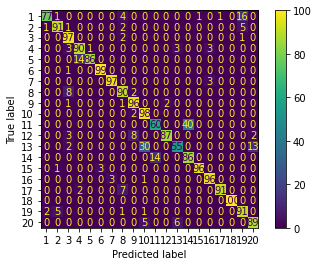

In [24]:
disp.plot()
plt.imshow()